In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
from IPython.display import display_html
from IPython.display import Image

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
%matplotlib inline

# dataset paths
posts_csv = r'\path\to\posts_df.csv'
pd.options.display.max_colwidth = 100

In [2]:
# Read in data
posts_df = pd.read_csv(posts_csv,encoding='utf8',index_col="Unnamed: 0")

# Filter only post from TDS, clean noisy titles and drop NaN
tds_only = posts_df[posts_df['publisher']=="Towards Data Science"]
tds_only = tds_only[(tds_only['user_name']!="TDS Team") & (tds_only['user_name']!="Benjamin Cooley")].dropna()

# Clean posted dates
def add_year(date):
    if "," not in date:
        date = date + ", 2020"
    return date

tds_only['date_posted'] = tds_only['date_posted'].apply(lambda x: pd.to_datetime(add_year(x)))

# Display df
print(tds_only.info())
tds_only

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3018 entries, 0 to 5476
Data columns (total 6 columns):
user_name      3018 non-null object
title          3018 non-null object
publisher      3018 non-null object
claps          3018 non-null float64
date_posted    3018 non-null datetime64[ns]
read_time      3018 non-null float64
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 165.0+ KB
None


,user_name,title,publisher,claps,date_posted,read_time
0,Will Koehrsen,The Poisson Distribution and Poisson Process Explained,Towards Data Science,6800.0,2019-01-21,14.0
1,Will Koehrsen,A Data Science Conversation,Towards Data Science,172.0,2020-03-10,3.0
6,Will Koehrsen,Lessons from a Year in the Data Science Trenches,Towards Data Science,567.0,2019-12-10,13.0
8,Will Koehrsen,Most People Screw Up Multiple Percent Changes. Here’s How to Get Them Right.,Towards Data Science,320.0,2019-08-05,9.0
10,Will Koehrsen,Lessons on How to Lie with Statistics,Towards Data Science,1500.0,2019-07-29,18.0
...,...,...,...,...,...,...
5424,Tarun Acharya,Prime numbers and Goldbach’s conjecture visualization.,Towards Data Science,27.0,2019-06-24,3.0
5425,Tarun Acharya,Advanced Ensemble Classifiers,Towards Data Science,11.0,2019-06-15,3.0
5426,Tarun Acharya,Regression with Regularization Techniques.,Towards Data Science,34.0,2019-06-07,3.0
5462,Carl Dombrowski,The top 5 best Chatbot and Natural Language Processing Tools to Build Ai for your Business,Towards Data Science,1100.0,2017-12-31,5.0


In [3]:
# Convert title column to list
data = tds_only['title'].tolist()

In [4]:
# Lowercasing and removal of punctuations

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Substitute versions numbers to "version_num"
data = [re.sub("([0-9]{1,2}.[0-9]{1,2})", "version_num", sent) for sent in data]

# Substitute numerical numbers to "num_sub"
data = [re.sub("[0-9]{1,4}", "num_sub", sent) for sent in data]
        
data_words = list(sent_to_words(data))

print("Samples: \n")
print(f"Before: {data[2]}")
print(f"After: {data_words[2]} \n")
print(f"Before: {data[133]}")
print(f"After: {data_words[133]}")

Samples: 

Before: Lessons from a Year in the Data Science Trenches
After: ['lessons', 'from', 'year', 'in', 'the', 'data', 'science', 'trenches'] 

Before: num_sub Things You Should Know about Scikit-Learn version_num 🎉
After: ['num_sub', 'things', 'you', 'should', 'know', 'about', 'scikit', 'learn', 'version_num']


In [5]:
# Lemmatization

def lemmatization(texts):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        temp = " ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc])
        # Compresses double spaces
        texts_out.append(" ".join(temp.split()))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
# If symbolic link was not created during the download, point path directly to 'en_core_web_sm'
nlp = spacy.load(r'C:\Users\ssptit\AppData\Local\Continuum\anaconda3\envs\deeplearn\lib\site-packages\en_core_web_sm\en_core_web_sm-2.2.5', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words)

# Note: Spacy lemmatizes all pronouns to "-PRON-". i.e. you, me, i etc.
print("Samples: \n")
print(data_lemmatized[1],"\n")
print(data_lemmatized[133])

Samples: 

datum science conversation 

num_sub thing should know about scikit learn version_num


In [6]:
# Create bigrams
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

# Tokenize to list
words = []
for sent in data_lemmatized:
    for token in sent.split():
        words.append(token)
        
# Create bigram with pmi
finder = BigramCollocationFinder.from_words(words)
bgm = BigramAssocMeasures()
score = bgm.mi_like
collocations = {'_'.join(bigram): pmi for bigram, pmi in finder.score_ngrams(score)}

# Create dictionary of meaningful bigrams
bigram_list = {}
for bigram, pmi in finder.score_ngrams(score):
    if pmi > 1:
        bigram_list[' '.join(bigram)] = '_'.join(bigram)

# Creat function to replace bigrams
def replace_to_bigrams(sentence):
    for k,v in bigram_list.items():
        if sentence.find(k) > 0:
            sentence = sentence.replace(k,v)
    return sentence

# Replace bigrams
data_lemmatized = [replace_to_bigrams(sent) for sent in data_lemmatized]
data_lemmatized

['the poisson distribution and poisson process explain',
 'datum science conversation',
 'lesson from year in the datum_science trench',
 'most people screw up multiple percent change here how_to get right',
 'lesson on how_to lie with statistic',
 'how num_sub of driver can be above average or why need to be careful when use statistic',
 'thought on the two culture of statistical modeling',
 'how to avoid common difficulty in data_science programming environment',
 'data scientist variable name be awful here how_to fix',
 'note on software construction from code complete',
 'how to generate prediction interval with scikit_learn and python',
 'be the job of datum_scientist at risk of be automate',
 'set jupyter_notebook up right with this extension',
 'datum science public service announcement',
 'how to automatically import favorite library into ipython or jupyter_notebook',
 'predict the frequency of asteroid impact with poisson process',
 'what learn from write datum_science article

In [7]:
# Creating the doc by term matrix for LDA

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=15,                       # minimum read occurences of a word 
                             stop_words='english',             # remove stop words
                             # token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=10000,             # max number of unique words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)
data_vectorized

<3018x169 sparse matrix of type '<class 'numpy.int64'>'
	with 6707 stored elements in Compressed Sparse Row format>

In [8]:
# Get sparse data matrix
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.314989745942491 %


C:\Users\ssptit\AppData\Local\Continuum\anaconda3\envs\deeplearn\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -12322.643582273891
Model Perplexity:  162.42757080633766


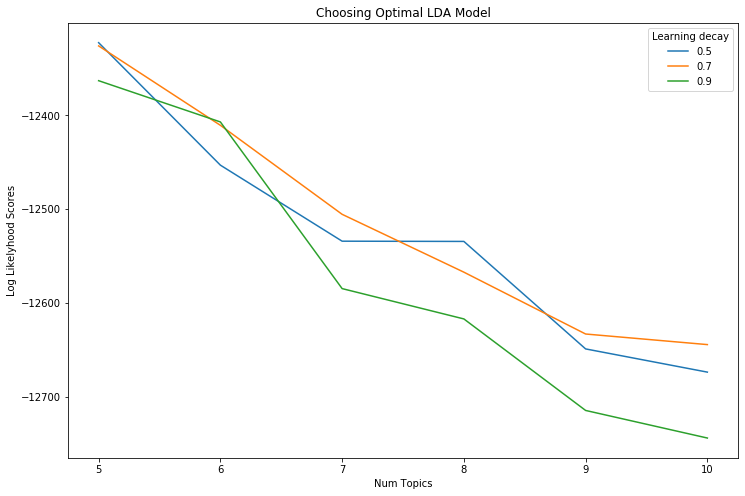

In [9]:
# GridSearch best LDA model - extended search

# Define Search Param
search_params = {'n_components': [5, 6, 7, 8, 9, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(learning_method='online',batch_size=64, max_iter=50)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, n_jobs=-1)

# Do the Grid Search
model.fit(data_vectorized)

# Model Performance - extended

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

# Compare Model Charts - extended

# Get Log Likelyhoods from Grid Search Output
n_components = [5, 6, 7, 8, 9, 10]
log_likelyhoods_5 = model.cv_results_["mean_test_score"][0:6]
log_likelyhoods_7 = model.cv_results_["mean_test_score"][6:12]
log_likelyhoods_9 = model.cv_results_["mean_test_score"][12:]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_components, log_likelyhoods_5, label='0.5')
plt.plot(n_components, log_likelyhoods_7, label='0.7')
plt.plot(n_components, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [10]:
model

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=64,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=50,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -13011.56181720116
Model Perplexity:  161.1723696069446

In [11]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.07,0.73,0.07,0.07,0.07,1
Doc1,0.07,0.07,0.07,0.73,0.07,3
Doc2,0.1,0.6,0.1,0.1,0.1,1
Doc3,0.4,0.07,0.07,0.4,0.07,0
Doc4,0.4,0.4,0.07,0.07,0.07,0
Doc5,0.04,0.64,0.24,0.04,0.04,1
Doc6,0.2,0.2,0.2,0.2,0.2,0
Doc7,0.73,0.07,0.07,0.07,0.07,0
Doc8,0.4,0.4,0.07,0.07,0.07,0
Doc9,0.07,0.73,0.07,0.07,0.07,1


In [12]:
# Topic distribution
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,1003
1,1,656
2,2,590
3,4,436
4,3,333


In [13]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\ssptit\AppData\Local\Continuum\anaconda3\envs\deeplearn\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2     -276.479401   -7.313981       1        1  22.133580
4      262.217712   96.384918       2        1  21.813909
1      -32.803329  215.217590       3        1  20.716621
0      284.101105 -232.877335       4        1  18.386328
3      -34.384605 -214.993408       5        1  16.949561, topic_info=    Category        Freq       Term       Total  loglift  logprob
37   Default  278.000000      datum  278.000000  30.0000  30.0000
106  Default  247.000000    num_sub  247.000000  29.0000  29.0000
157  Default  246.000000        use  246.000000  28.0000  28.0000
72   Default  146.000000  in_python  146.000000  27.0000  27.0000
0    Default  158.000000         ai  158.000000  26.0000  26.0000
..       ...         ...        ...         ...      ...      ...
17    Topic5    0.213152       bias   17.639255  -2.6409  -8.5952
158   Topic5    0.212941     useful   17.656988  -2.6429  -8.5962
67    Topic5    0.212759     handle   17.793446  -2.6515  -8.5971
18    Topic5    0.212584        big   18.415351  -2.6867  -8.5979
96    Topic5    0.213159     method   34.728939  -3.3184  -8.5952

[189 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         2  0.991952         ai
1         2  0.988627  algorithm
2         2  0.988686   analysis
3         1  0.970407   analytic
4         5  0.969822    analyze
...     ...       ...        ...
164       4  0.984692        web
165       3  0.948460       word
166       4  0.964806       work
167       4  0.980979      world
168       4  0.943527      write

[154 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 1, 4])

In [14]:
# View top 15 Topic keywords

# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,in_python,chart,version_num,data_science,deep_learning,make,visualization,introduction,quality,example,method,how_to,sql,kera,function
Topic 1,num_sub,data,datum_science,learning,machine,know,learn,code,explain,simple,need,new,data_scientist,optimization,way
Topic 2,use,learn,part_num_sub,build,neural_network,deep,datum_scientist,classification,predict,text,image,guide_to,start,reinforcement,regression
Topic 3,datum,machine_learning,science,understand,project,good,feature,control,tool,introduction_to,analyze,network,explore,step,game
Topic 4,ai,python,model,analysis,algorithm,machine_learn,pandas,google,for_datum_science,create,business,dataset,artificial,intelligence,api


In [15]:
# LDA 7 topics

lda_seven_topics = LatentDirichletAllocation(n_components=7,             
                                      learning_decay=0.5,
                                      learning_offset=10.0,
                                      max_iter=50,         
                                      learning_method='online',   
                                      random_state=100,          
                                      batch_size=32,            
                                      evaluate_every = -1,       
                                      n_jobs = -1  
                                     )

lda_seven_output = lda_seven_topics.fit_transform(data_vectorized)

In [16]:
panel = pyLDAvis.sklearn.prepare(lda_seven_topics, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\ssptit\AppData\Local\Continuum\anaconda3\envs\deeplearn\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2       5.291765 -11.699995       1        1  17.723728
5      -1.110977   3.893038       2        1  15.771237
6     -11.416017  -9.446850       3        1  14.763528
0      -5.017868 -25.038500       4        1  14.646456
4      22.005795 -13.956719       5        1  12.728690
3      11.697137 -27.294119       6        1  12.216562
1      15.602249   1.645766       7        1  12.149799, topic_info=    Category        Freq          Term       Total  loglift  logprob
157  Default  273.000000           use  273.000000  30.0000  30.0000
37   Default  267.000000         datum  267.000000  29.0000  29.0000
106  Default  249.000000       num_sub  249.000000  28.0000  28.0000
0    Default  166.000000            ai  166.000000  27.0000  27.0000
84   Default  153.000000         learn  153.000000  26.0000  26.0000
..       ...         ...           ...         ...      ...      ...
87    Topic7    0.151717          like   17.733067  -2.6533  -8.6023
8     Topic7    0.151810    artificial   30.244913  -3.1866  -8.6017
116   Topic7    0.151715       process   27.251284  -3.0830  -8.6023
21    Topic7    0.151713      business   27.771152  -3.1019  -8.6023
57    Topic7    0.151702  from_scratch   23.370544  -2.9295  -8.6024

[293 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         7  0.995156         ai
1         1  0.979958  algorithm
2         5  0.993114   analysis
3         5  0.965063   analytic
4         2  0.970900    analyze
...     ...       ...        ...
164       6  0.972552        web
165       3  0.961249       word
166       5  0.985323       work
167       5  0.964290      world
168       6  0.955398      write

[169 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 7, 1, 5, 4, 2])

In [17]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_seven_topics, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = [i for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
0,in_python,version_num,deep,classification,pandas,visualization,predict,text,image,guide_to,start,function,tool,nlp,regression
1,ai,learning,make,explain,for_datum_science,network,intelligence,artificial_intelligence,base,classifier,panda,search,bert,easy,human
2,model,machine_learning,build,deep_learning,neural_network,machine,algorithm,machine_learn,good,feature,example,data_scientist,kera,create,quality
3,learn,datum_science,part_num_sub,chart,sql,reinforcement,method,how_to,api,explore,web,handle,right,bias,useful
4,data,analysis,data_science,understand,simple,introduction_to,dataset,time,analytic,artificial,world,ml,work,linear,for_datum_scientist
5,datum,python,science,datum_scientist,introduction,project,code,analyze,control,complete,time_series,step,detection,job,team
6,use,num_sub,know,new,google,need,tensorflow,deep_learn,tip,graph,word,technique,basic,big,cloud


In [18]:
# Create topics
topic_names = ['feature and functions guides, posts on visualization, pandas or jupyter notebook','any topics on AI, explaing ML concepts, links to book resources',
                'examples on building AI/ML models, tutorial type post, post on kaggle projects','what to learn to enter DS field, "how-to" like posts on data science',
                'introduction to data science, understanding ML theory, some posts about data science interviews', 'posts about data, posts about the DS experiences',
                'tip and tricks, tensor flow, cloud, techniques']

df_topic_names = pd.DataFrame(data=topic_names,columns=['topic_names'])

df_topic_names['topic_id'] = [i for i in range(len(topic_names))]

df_topic_names.set_index("topic_id", inplace=True) 

df_topic_names

,topic_names
topic_id,
0,"feature and functions guides, posts on visualization, pandas or jupyter notebook"
1,"any topics on AI, explaing ML concepts, links to book resources"
2,"examples on building AI/ML models, tutorial type post, post on kaggle projects"
3,"what to learn to enter DS field, ""how-to"" like posts on data science"
4,"introduction to data science, understanding ML theory, some posts about data science interviews"
5,"posts about data, posts about the DS experiences"
6,"tip and tricks, tensor flow, cloud, techniques"


In [19]:
# Create Document - Topic Matrix

# column names
topicnames = ["Topic" + str(i) for i in range(lda_seven_topics.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_seven_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,dominant_topic
Doc0,0.38,0.38,0.05,0.05,0.05,0.05,0.05,0
Doc1,0.05,0.05,0.05,0.05,0.05,0.71,0.05,5
Doc2,0.07,0.07,0.07,0.57,0.07,0.07,0.07,3
Doc3,0.05,0.05,0.05,0.71,0.05,0.05,0.05,3
Doc4,0.05,0.05,0.05,0.38,0.05,0.05,0.38,3
Doc5,0.03,0.03,0.03,0.03,0.03,0.03,0.83,6
Doc6,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0
Doc7,0.05,0.05,0.05,0.05,0.71,0.05,0.05,4
Doc8,0.05,0.05,0.05,0.38,0.38,0.05,0.05,3
Doc9,0.05,0.05,0.05,0.05,0.05,0.71,0.05,5


In [20]:
# Topic distribution
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['topic_id', 'num_documents']
df_topic_distribution.set_index('topic_id',inplace=True)
df_topic_distribution['percentage'] = df_topic_distribution['num_documents'].apply(lambda x: str(round(x/float(df_topic_distribution['num_documents'].sum()),3) * 100) + "%" )
df_topic_distribution

,num_documents,percentage
topic_id,,
0,934,30.9%
2,572,19.0%
1,453,15.0%
5,308,10.2%
4,268,8.9%
3,262,8.7%
6,221,7.3%


In [21]:
# Merge topics to main tds table
topic_df_temp = df_topic_names.reset_index()
topic_merge = pd.merge(df_document_topic,topic_df_temp,how='left',left_on='dominant_topic',right_on='topic_id')
topic_merge.drop(columns=['Topic0','Topic1','Topic2','Topic3','Topic4','Topic5','Topic6','dominant_topic'], axis=1, inplace=True)
tds_only.reset_index(inplace=True)
tds_only.drop(columns=['index'],axis=1,inplace=True)
tds_topics = pd.merge(tds_only,topic_merge,how='left',left_index=True,right_index=True)
print(tds_topics.info())
tds_topics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3018 entries, 0 to 3017
Data columns (total 8 columns):
user_name      3018 non-null object
title          3018 non-null object
publisher      3018 non-null object
claps          3018 non-null float64
date_posted    3018 non-null datetime64[ns]
read_time      3018 non-null float64
topic_id       3018 non-null int64
topic_names    3018 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 188.8+ KB
None


,user_name,title,publisher,claps,date_posted,read_time,topic_id,topic_names
0,Will Koehrsen,The Poisson Distribution and Poisson Process Explained,Towards Data Science,6800.0,2019-01-21,14.0,0,"feature and functions guides, posts on visualization, pandas or jupyter notebook"
1,Will Koehrsen,A Data Science Conversation,Towards Data Science,172.0,2020-03-10,3.0,5,"posts about data, posts about the DS experiences"
2,Will Koehrsen,Lessons from a Year in the Data Science Trenches,Towards Data Science,567.0,2019-12-10,13.0,3,"what to learn to enter DS field, ""how-to"" like posts on data science"
3,Will Koehrsen,Most People Screw Up Multiple Percent Changes. Here’s How to Get Them Right.,Towards Data Science,320.0,2019-08-05,9.0,3,"what to learn to enter DS field, ""how-to"" like posts on data science"
4,Will Koehrsen,Lessons on How to Lie with Statistics,Towards Data Science,1500.0,2019-07-29,18.0,3,"what to learn to enter DS field, ""how-to"" like posts on data science"
...,...,...,...,...,...,...,...,...
3013,Tarun Acharya,Prime numbers and Goldbach’s conjecture visualization.,Towards Data Science,27.0,2019-06-24,3.0,0,"feature and functions guides, posts on visualization, pandas or jupyter notebook"
3014,Tarun Acharya,Advanced Ensemble Classifiers,Towards Data Science,11.0,2019-06-15,3.0,1,"any topics on AI, explaing ML concepts, links to book resources"
3015,Tarun Acharya,Regression with Regularization Techniques.,Towards Data Science,34.0,2019-06-07,3.0,0,"feature and functions guides, posts on visualization, pandas or jupyter notebook"
3016,Carl Dombrowski,The top 5 best Chatbot and Natural Language Processing Tools to Build Ai for your Business,Towards Data Science,1100.0,2017-12-31,5.0,2,"examples on building AI/ML models, tutorial type post, post on kaggle projects"


In [22]:
# Split date to year and month_year
tds_topics['year_posted'] = tds_topics['date_posted'].apply(lambda dp: dp.year)
tds_topics['month_year'] = pd.to_datetime(tds_topics['date_posted']).dt.to_period('M')

In [23]:
tds_topics

,user_name,title,publisher,claps,date_posted,read_time,topic_id,topic_names,year_posted,month_year
0,Will Koehrsen,The Poisson Distribution and Poisson Process Explained,Towards Data Science,6800.0,2019-01-21,14.0,0,"feature and functions guides, posts on visualization, pandas or jupyter notebook",2019,2019-01
1,Will Koehrsen,A Data Science Conversation,Towards Data Science,172.0,2020-03-10,3.0,5,"posts about data, posts about the DS experiences",2020,2020-03
2,Will Koehrsen,Lessons from a Year in the Data Science Trenches,Towards Data Science,567.0,2019-12-10,13.0,3,"what to learn to enter DS field, ""how-to"" like posts on data science",2019,2019-12
3,Will Koehrsen,Most People Screw Up Multiple Percent Changes. Here’s How to Get Them Right.,Towards Data Science,320.0,2019-08-05,9.0,3,"what to learn to enter DS field, ""how-to"" like posts on data science",2019,2019-08
4,Will Koehrsen,Lessons on How to Lie with Statistics,Towards Data Science,1500.0,2019-07-29,18.0,3,"what to learn to enter DS field, ""how-to"" like posts on data science",2019,2019-07
...,...,...,...,...,...,...,...,...,...,...
3013,Tarun Acharya,Prime numbers and Goldbach’s conjecture visualization.,Towards Data Science,27.0,2019-06-24,3.0,0,"feature and functions guides, posts on visualization, pandas or jupyter notebook",2019,2019-06
3014,Tarun Acharya,Advanced Ensemble Classifiers,Towards Data Science,11.0,2019-06-15,3.0,1,"any topics on AI, explaing ML concepts, links to book resources",2019,2019-06
3015,Tarun Acharya,Regression with Regularization Techniques.,Towards Data Science,34.0,2019-06-07,3.0,0,"feature and functions guides, posts on visualization, pandas or jupyter notebook",2019,2019-06
3016,Carl Dombrowski,The top 5 best Chatbot and Natural Language Processing Tools to Build Ai for your Business,Towards Data Science,1100.0,2017-12-31,5.0,2,"examples on building AI/ML models, tutorial type post, post on kaggle projects",2017,2017-12


# What posts are Writers publishing?

In [24]:
# Group-by topic_id and year_posted
topics_bygroup = tds_topics.groupby(["topic_id","year_posted"])
bygroup_freq = topics_bygroup.size().to_frame().reset_index()
bygroup_freq.head()

,topic_id,year_posted,0
0,0,2015,1
1,0,2016,1
2,0,2017,53
3,0,2018,172
4,0,2019,487


In [25]:
# Extract bygroup frequency counts
for i in range(7):
    globals()["topic"+str(i)+"_freq"] = bygroup_freq[bygroup_freq["topic_id"]==i][0].to_list()
    globals()["year"+str(i)+"_list"] = bygroup_freq[bygroup_freq["topic_id"]==i]["year_posted"].to_list()

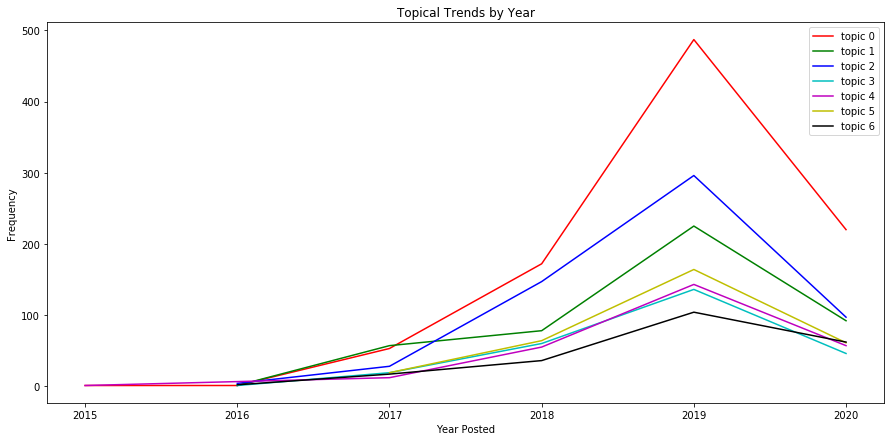

,topic_names
topic_id,
0,"feature and functions guides, posts on visualization, pandas or jupyter notebook"
1,"any topics on AI, explaing ML concepts, links to book resources"
2,"examples on building AI/ML models, tutorial type post, post on kaggle projects"
3,"what to learn to enter DS field, ""how-to"" like posts on data science"
4,"introduction to data science, understanding ML theory, some posts about data science interviews"
5,"posts about data, posts about the DS experiences"
6,"tip and tricks, tensor flow, cloud, techniques"


In [26]:
plt.figure(figsize=(15,7))
plt.plot(year0_list,topic0_freq, 'r-',label="topic 0")
plt.plot(year1_list,topic1_freq, 'g-',label="topic 1")
plt.plot(year2_list,topic2_freq, 'b-',label="topic 2")
plt.plot(year3_list,topic3_freq, 'c-',label="topic 3")
plt.plot(year4_list,topic4_freq, 'm-',label="topic 4")
plt.plot(year5_list,topic5_freq, 'y-',label="topic 5")
plt.plot(year6_list,topic6_freq, 'k-',label="topic 6")
plt.xlabel('Year Posted')
plt.ylabel('Frequency')
plt.title('Topical Trends by Year')
plt.legend()
plt.show()
df_topic_names

In [27]:
# Group-by topic_id and month_year
tds_topics['month_year_cat'] = tds_topics['month_year'].apply(lambda x: str(x))
topics_bygroup2 = tds_topics.groupby(["topic_id","month_year_cat"])
bygroup_freq2 = topics_bygroup2.size().to_frame().reset_index()
bygroup_freq2.head()

,topic_id,month_year_cat,0
0,0,2015-05,1
1,0,2016-12,1
2,0,2017-02,1
3,0,2017-03,1
4,0,2017-04,1


In [28]:
# Filter year 2015 and 2016
notin_year_2015_2016 = [date for date in bygroup_freq2['month_year_cat'].to_list() if date[0:4] not in ["2015","2016"]]
bygroup_filtered = bygroup_freq2[bygroup_freq2['month_year_cat'].isin(notin_year_2015_2016)]

In [29]:
# Extract bygroup frequency counts
for i in range(7):
    globals()["topic"+str(i)+"_freq2"] = bygroup_filtered[(bygroup_filtered["topic_id"]==i) & (bygroup_filtered['month_year_cat']!="2020-05") & (bygroup_filtered['month_year_cat']!="2017-01")][0].to_list()
    globals()["year"+str(i)+"_list2"] = bygroup_filtered[(bygroup_filtered["topic_id"]==i) & (bygroup_filtered['month_year_cat']!="2020-05") & (bygroup_filtered['month_year_cat']!="2017-01")]["month_year_cat"].to_list()

In [30]:
# Create average frequency of posts per topic
for i in range(7):
    temp_avg_topic = []
    temp_avg_topic.append(round(np.mean(globals()["topic"+str(i)+"_freq2"]),2))
    globals()["avg_topic"+str(i)+"_freq2"] = temp_avg_topic * len(globals()["topic"+str(i)+"_freq2"])

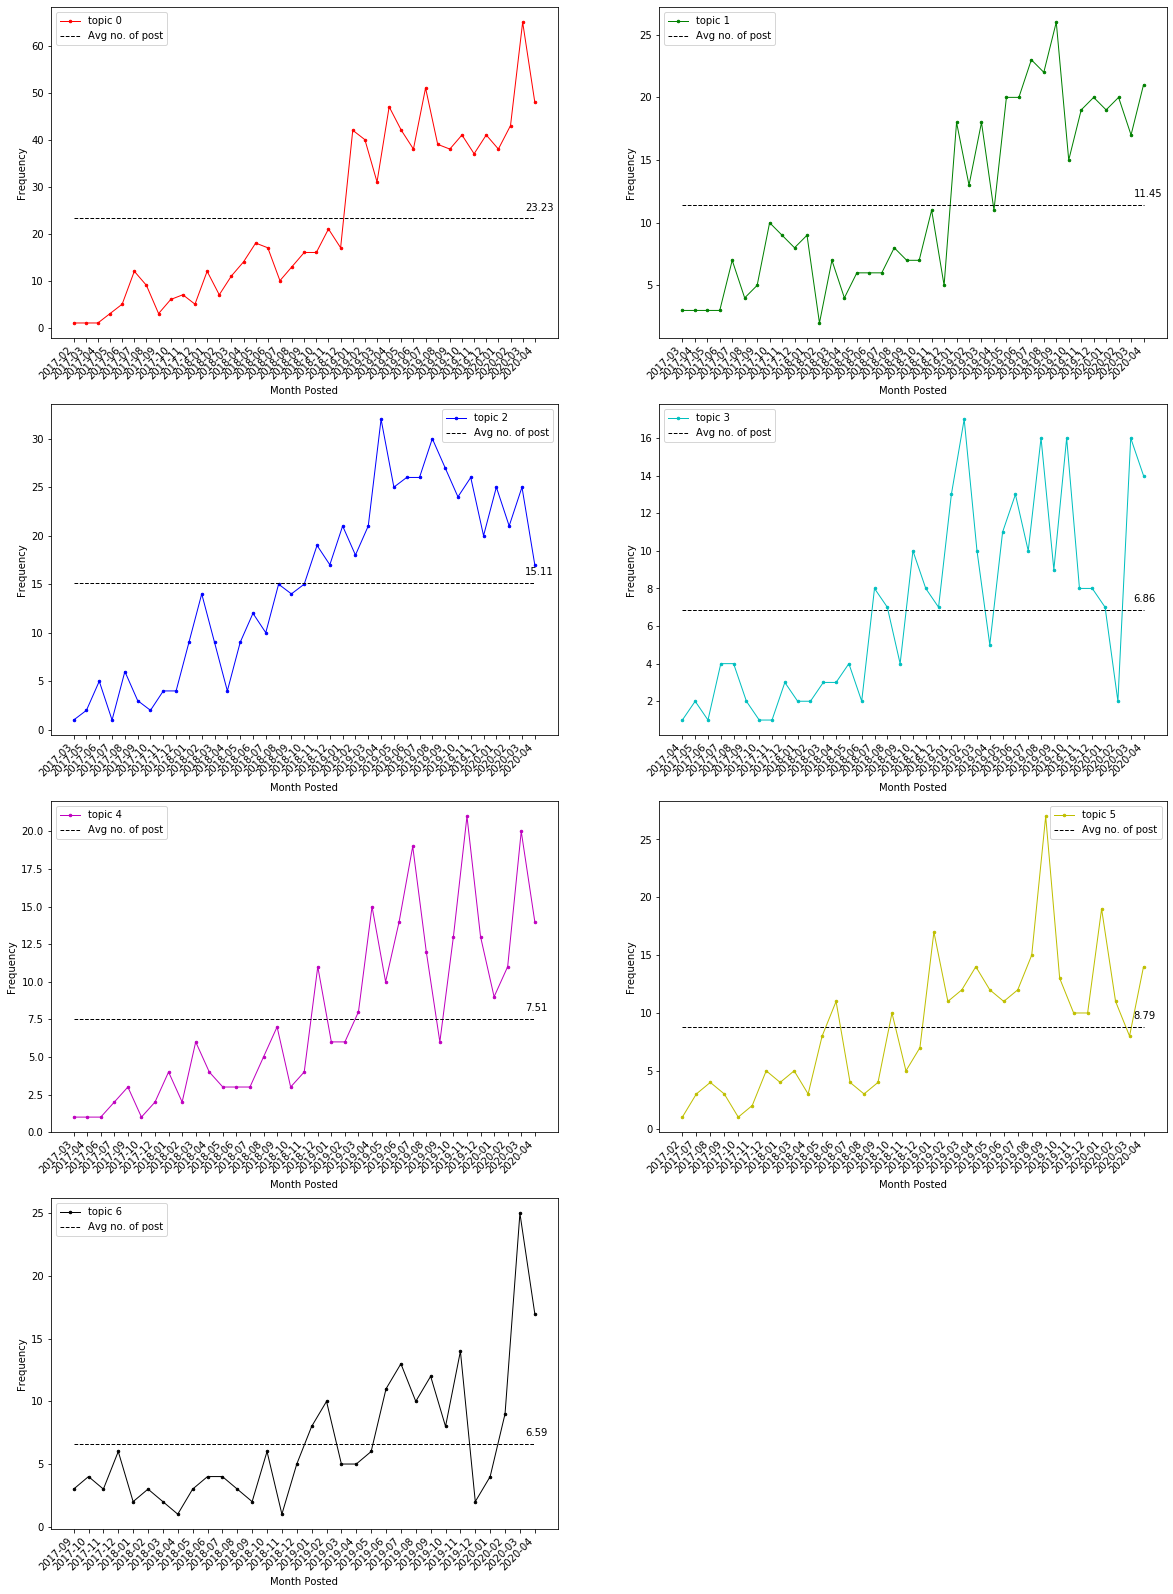

In [31]:
plt.figure(figsize=(20,28))

plt.subplot(4,2,1)
plt.plot(year0_list2,topic0_freq2, 'r-',label="topic 0",lw=1,marker='o',markersize=2.5)
plt.plot(year0_list2,avg_topic0_freq2, '--',label="Avg no. of post",lw=1,c='k')
plt.annotate(avg_topic0_freq2[-1],(year0_list2[-1],avg_topic0_freq2[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(4,2,2)
plt.plot(year1_list2,topic1_freq2, 'g-',label="topic 1",lw=1,marker='o',markersize=2.5)
plt.plot(year1_list2,avg_topic1_freq2, '--',label="Avg no. of post",lw=1,c='k')
plt.annotate(avg_topic1_freq2[-1],(year1_list2[-1],avg_topic1_freq2[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(4,2,3)
plt.plot(year2_list2,topic2_freq2, 'b-',label="topic 2",lw=1,marker='o',markersize=2.5)
plt.plot(year2_list2,avg_topic2_freq2, '--',label="Avg no. of post",lw=1,c='k')
plt.annotate(avg_topic2_freq2[-1],(year2_list2[-1],avg_topic2_freq2[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(4,2,4)
plt.plot(year3_list2,topic3_freq2, 'c-',label="topic 3",lw=1,marker='o',markersize=2.5)
plt.plot(year3_list2,avg_topic3_freq2, '--',label="Avg no. of post",lw=1,c='k')
plt.annotate(avg_topic3_freq2[-1],(year3_list2[-1],avg_topic3_freq2[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(4,2,5)
plt.plot(year4_list2,topic4_freq2, 'm-',label="topic 4",lw=1,marker='o',markersize=2.5)
plt.plot(year4_list2,avg_topic4_freq2, '--',label="Avg no. of post",lw=1,c='k')
plt.annotate(avg_topic4_freq2[-1],(year4_list2[-1],avg_topic4_freq2[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(4,2,6)
plt.plot(year5_list2,topic5_freq2, 'y-',label="topic 5",lw=1,marker='o',markersize=2.5)
plt.plot(year5_list2,avg_topic5_freq2, '--',label="Avg no. of post",lw=1,c='k')
plt.annotate(avg_topic5_freq2[-1],(year5_list2[-1],avg_topic5_freq2[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(4,2,7)
plt.plot(year6_list2,topic6_freq2, 'k-',label="topic 6",lw=1,marker='o',markersize=2.5)
plt.plot(year6_list2,avg_topic6_freq2, '--',label="Avg no. of post",lw=1,c='k')
plt.annotate(avg_topic6_freq2[-1],(year6_list2[-1],avg_topic6_freq2[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.show()

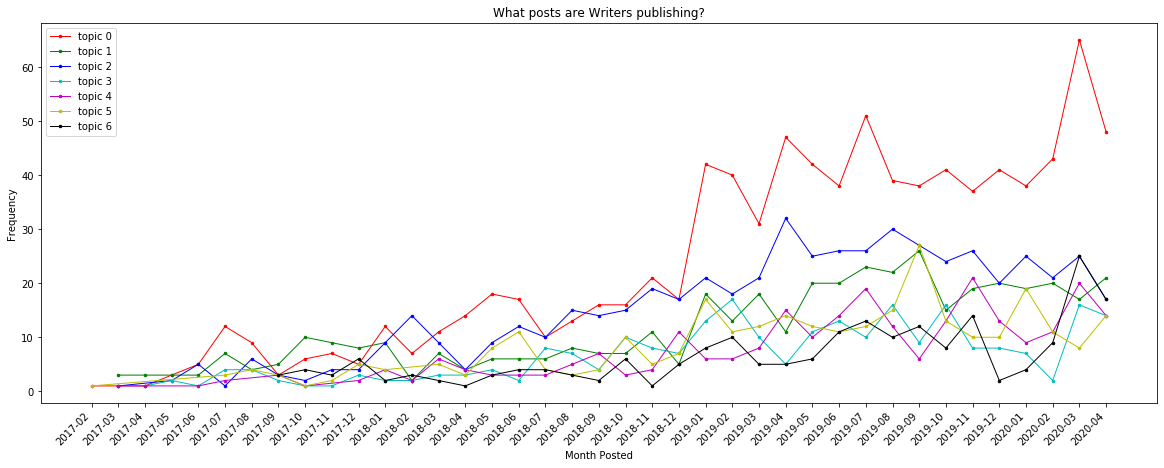

topic_names 
 
 
 topic_id 
 
 
 
 
 
 0 
 feature and functions guides, posts on visualization, pandas or jupyter notebook 
 
 
 1 
 any topics on AI, explaing ML concepts, links to book resources 
 
 
 2 
 examples on building AI/ML models, tutorial type post, post on kaggle projects 
 
 
 3 
 what to learn to enter DS field, "how-to" like posts on data science 
 
 
 4 
 introduction to data science, understanding ML theory, some posts about data science interviews 
 
 
 5 
 posts about data, posts about the DS experiences 
 
 
 6 
 tip and tricks, tensor flow, cloud, techniques 
 
 
 
 
 
 
 num_documents 
 percentage 
 
 
 topic_id 
 
 
 
 
 
 
 0 
 934 
 30.9% 
 
 
 2 
 572 
 19.0% 
 
 
 1 
 453 
 15.0% 
 
 
 5 
 308 
 10.2% 
 
 
 4 
 268 
 8.9% 
 
 
 3 
 262 
 8.7% 
 
 
 6 
 221 
 7.3%

In [32]:
plt.figure(figsize=(20,7))
plt.plot(year0_list2,topic0_freq2, 'r-',label="topic 0",lw=1,marker='o',markersize=2.5)
plt.plot(year1_list2,topic1_freq2, 'g-',label="topic 1",lw=1,marker='o',markersize=2.5)
plt.plot(year2_list2,topic2_freq2, 'b-',label="topic 2",lw=1,marker='o',markersize=2.5)
plt.plot(year3_list2,topic3_freq2, 'c-',label="topic 3",lw=1,marker='o',markersize=2.5)
plt.plot(year4_list2,topic4_freq2, 'm-',label="topic 4",lw=1,marker='o',markersize=2.5)
plt.plot(year5_list2,topic5_freq2, 'y-',label="topic 5",lw=1,marker='o',markersize=2.5)
plt.plot(year6_list2,topic6_freq2, 'k-',label="topic 6",lw=1,marker='o',markersize=2.5)
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.title("What posts are Writers publishing?")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()

display_side_by_side(df_topic_names,df_topic_distribution)

# What posts are Readers interested in? 
### Note: Took claps as proxy for interest
##### Very High Interest: >= 1k claps
##### High Interest: 500 <= claps < 1k
##### Decent Interest: 150 <= claps < 500
##### Lower Interest: <150 claps

In [33]:
# Create interest groupings

def label_group(df):
    if df['claps'] >= 1000:
        return "Very High Interest"
    elif df['claps'] >= 500 and df['claps'] < 1000:
        return "High Interest"
    elif df['claps'] >= 150 and df['claps'] < 500:
        return "Decent Interest"
    else:
        return "Lower Interest"

# Pass df into .apply to do labelling
tds_topics['Interest Grouping'] = tds_topics.apply(lambda row: label_group(row), axis=1)
        
tds_topics.head()

,user_name,title,publisher,claps,date_posted,read_time,topic_id,topic_names,year_posted,month_year,month_year_cat,Interest Grouping
0,Will Koehrsen,The Poisson Distribution and Poisson Process Explained,Towards Data Science,6800.0,2019-01-21,14.0,0,"feature and functions guides, posts on visualization, pandas or jupyter notebook",2019,2019-01,2019-01,Very High Interest
1,Will Koehrsen,A Data Science Conversation,Towards Data Science,172.0,2020-03-10,3.0,5,"posts about data, posts about the DS experiences",2020,2020-03,2020-03,Decent Interest
2,Will Koehrsen,Lessons from a Year in the Data Science Trenches,Towards Data Science,567.0,2019-12-10,13.0,3,"what to learn to enter DS field, ""how-to"" like posts on data science",2019,2019-12,2019-12,High Interest
3,Will Koehrsen,Most People Screw Up Multiple Percent Changes. Here’s How to Get Them Right.,Towards Data Science,320.0,2019-08-05,9.0,3,"what to learn to enter DS field, ""how-to"" like posts on data science",2019,2019-08,2019-08,Decent Interest
4,Will Koehrsen,Lessons on How to Lie with Statistics,Towards Data Science,1500.0,2019-07-29,18.0,3,"what to learn to enter DS field, ""how-to"" like posts on data science",2019,2019-07,2019-07,Very High Interest


In [34]:
# Create by-group with interest grouping
claps_bygroup = tds_topics.groupby(["topic_id","month_year_cat","Interest Grouping"])
claps_bygroup_freq = claps_bygroup.size().to_frame().reset_index()
claps_bygroup_freq.head()

,topic_id,month_year_cat,Interest Grouping,0
0,0,2015-05,Lower Interest,1
1,0,2016-12,Lower Interest,1
2,0,2017-02,Lower Interest,1
3,0,2017-03,Lower Interest,1
4,0,2017-04,Lower Interest,1


In [35]:
# Filter out current month due to incomplete data
claps_bygroup_filtered = claps_bygroup_freq[claps_bygroup_freq['month_year_cat']!="2020-05"]

In [36]:
# Extract bygroup frequency counts per interest grouping

def interest_group(grouping):
    
    # Filter interest grouping
    group_name = '_'.join(grouping.lower().split())
    globals()[group_name] = claps_bygroup_filtered[claps_bygroup_filtered["Interest Grouping"] == grouping]
    df = globals()[group_name]
    
    # Loop through each topic
    for i in range(7):
        globals()["topic"+str(i)+"_"+group_name] = df[df["topic_id"]==i][0].to_list()
        globals()["year"+str(i)+"_"+group_name] = df[df["topic_id"]==i]["month_year_cat"].to_list()
        # Append average to a list. Form a uniform list by multiplying with length of list. i.e. [5] * 3 = [5,5,5] where average no. of post = 5
        globals()["average"+str(i)+"_"+group_name] = []
        globals()["average"+str(i)+"_"+group_name].append(round(np.mean(df[df["topic_id"]==i][0].to_list()),2))
        globals()["average"+str(i)+"_"+group_name] = globals()["average"+str(i)+"_"+group_name] * len(df[df["topic_id"]==i][0].to_list())
        
for group in ["Very High Interest","High Interest","Decent Interest","Lower Interest"]:
    interest_group(group)

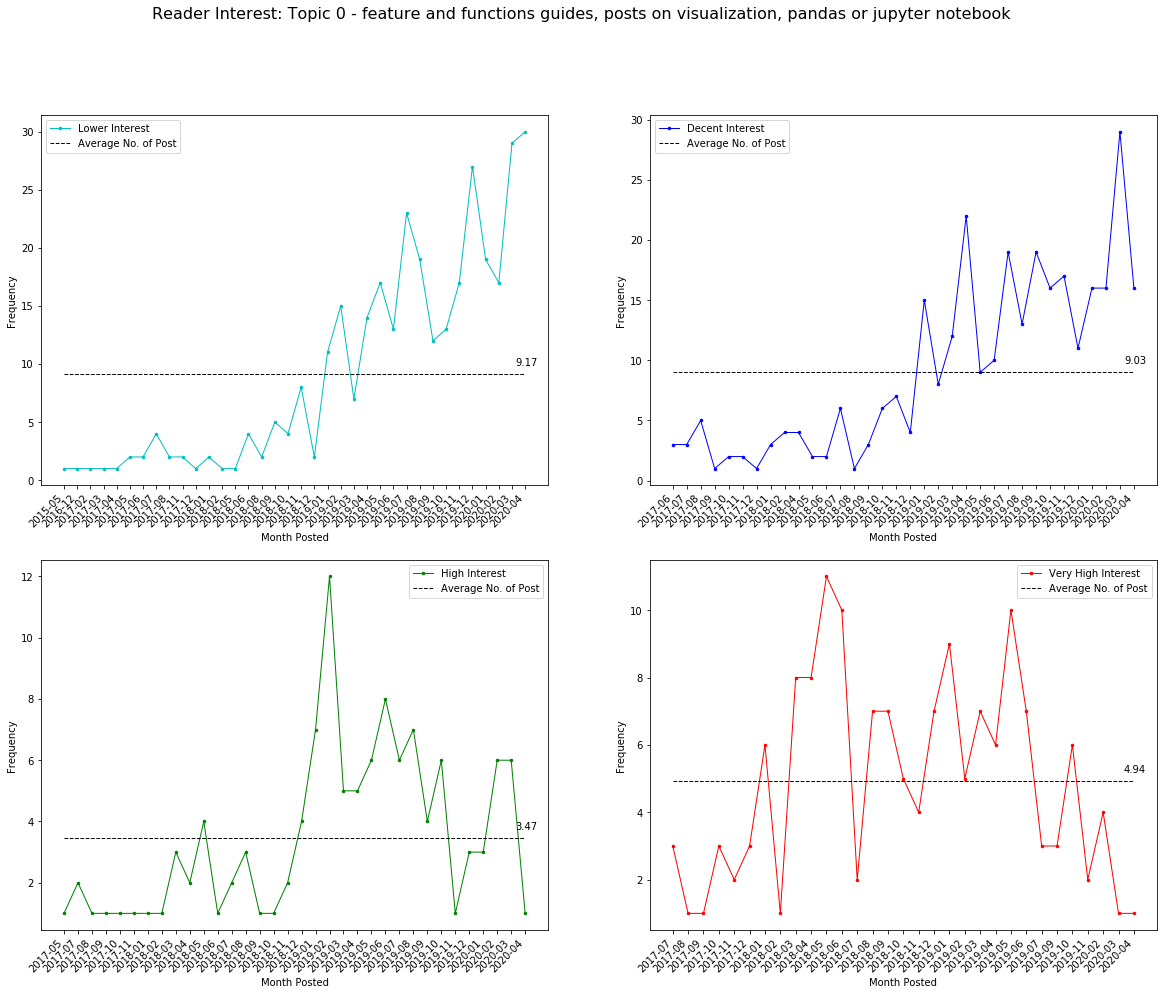

topic_names 
 
 
 topic_id 
 
 
 
 
 
 0 
 feature and functions guides, posts on visualization, pandas or jupyter notebook 
 
 
 1 
 any topics on AI, explaing ML concepts, links to book resources 
 
 
 2 
 examples on building AI/ML models, tutorial type post, post on kaggle projects 
 
 
 3 
 what to learn to enter DS field, "how-to" like posts on data science 
 
 
 4 
 introduction to data science, understanding ML theory, some posts about data science interviews 
 
 
 5 
 posts about data, posts about the DS experiences 
 
 
 6 
 tip and tricks, tensor flow, cloud, techniques 
 
 
 
 
 
 
 num_documents 
 percentage 
 
 
 topic_id 
 
 
 
 
 
 
 0 
 934 
 30.9% 
 
 
 2 
 572 
 19.0% 
 
 
 1 
 453 
 15.0% 
 
 
 5 
 308 
 10.2% 
 
 
 4 
 268 
 8.9% 
 
 
 3 
 262 
 8.7% 
 
 
 6 
 221 
 7.3% 
 
 
 
 
 
 
 Interest Grouping 
 frequency 
 percentage 
 
 
 topic_id 
 
 
 
 
 
 
 
 0 
 Decent Interest 
 310 
 33.0% 
 
 
 0 
 High Interest 
 119 
 13.0% 
 
 
 0 
 Lower Interest 
 352 
 38.0% 
 
 
 0 
 Very High Interest 
 153 
 16.0%

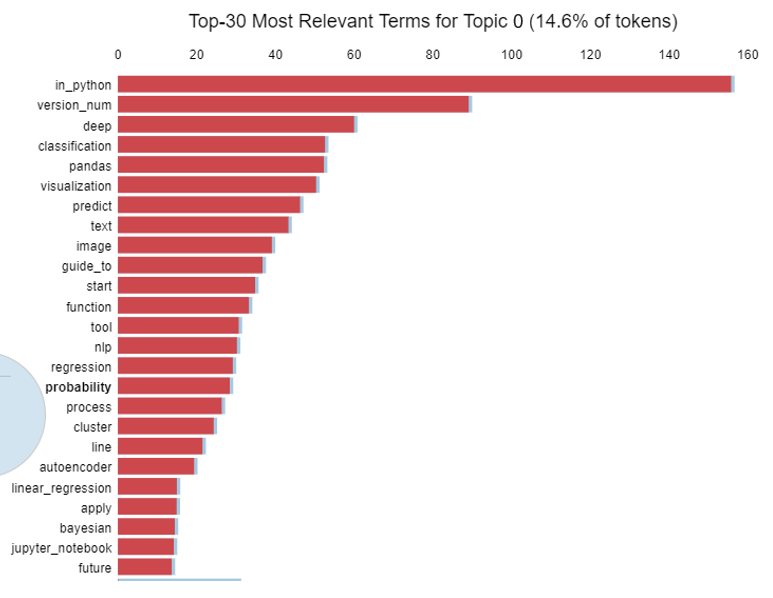

,title
31,How to Write a Jupyter Notebook Extension
32,Jupyter Notebook Extensions
34,Estimating Probabilities with Bayesian Modeling in Python
49,Converting Medium Posts to Markdown for Your Blog
53,An Implementation and Explanation of the Random Forest in Python
57,How to Visualize a Decision Tree from a Random Forest in Python using Scikit-Learn
58,Parallelizing Feature Engineering with Dask
63,Automated Machine Learning Hyperparameter Tuning in Python
64,An Introductory Example of Bayesian Optimization in Python with Hyperopt
66,A Feature Selection Tool for Machine Learning in Python


In [37]:
# Reader Interest for Topic 0

plt.figure(figsize=(20,15))
plt.suptitle('Reader Interest: Topic 0 - feature and functions guides, posts on visualization, pandas or jupyter notebook', fontsize=16)

plt.subplot(2,2,1)
plt.plot(year0_lower_interest,topic0_lower_interest, 'c-',label="Lower Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year0_lower_interest,average0_lower_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average0_lower_interest[-1],(year0_lower_interest[-1],average0_lower_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,2)
plt.plot(year0_decent_interest,topic0_decent_interest, 'b-',label="Decent Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year0_decent_interest,average0_decent_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average0_decent_interest[-1],(year0_decent_interest[-1],average0_decent_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,3)
plt.plot(year0_high_interest,topic0_high_interest, 'g-',label="High Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year0_high_interest,average0_high_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average0_high_interest[-1],(year0_high_interest[-1],average0_high_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,4)
plt.plot(year0_very_high_interest,topic0_very_high_interest, 'r-',label="Very High Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year0_very_high_interest,average0_very_high_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average0_very_high_interest[-1],(year0_very_high_interest[-1],average0_very_high_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.show()

interest_group_distribution = claps_bygroup_freq.groupby(["Interest Grouping","topic_id"]).sum()
interest_group_distribution.columns = ["frequency"]
temp_df = interest_group_distribution.reset_index().set_index("topic_id").loc[0]
temp_df['percentage'] = temp_df['frequency'].apply(lambda x: str(round(x/float(temp_df['frequency'].sum()),2) * 100) + "%" )

sample_df = tds_topics[tds_topics['topic_id']==0]['title'].to_frame()

display_side_by_side(df_topic_names,df_topic_distribution,temp_df)

display(Image(r"C:\Users\ssptit\OneDrive - SAS\Medium\tds_scrape\images\topic0_terms.png"))

display_side_by_side(sample_df[10:20],sample_df[100:110])

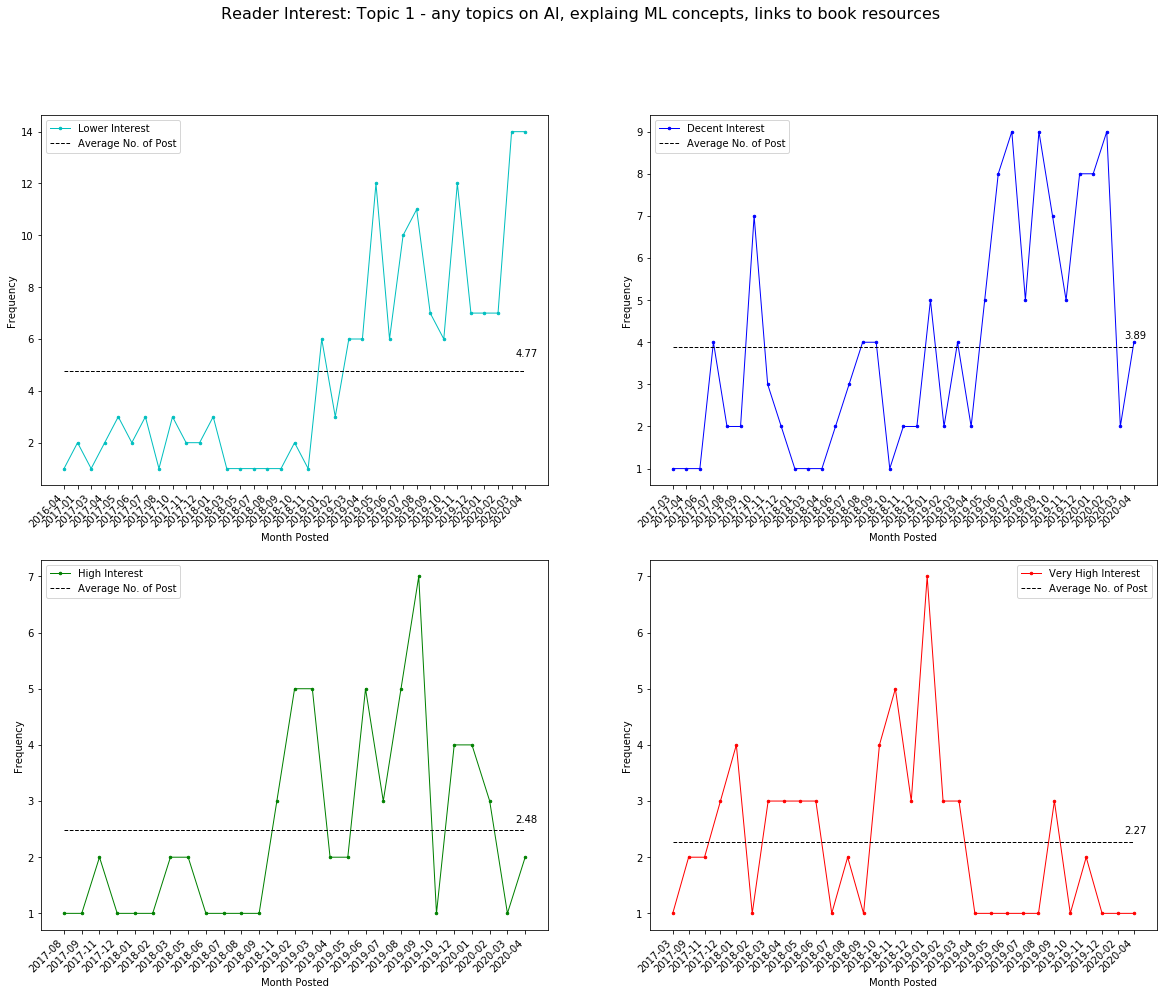

topic_names 
 
 
 topic_id 
 
 
 
 
 
 0 
 feature and functions guides, posts on visualization, pandas or jupyter notebook 
 
 
 1 
 any topics on AI, explaing ML concepts, links to book resources 
 
 
 2 
 examples on building AI/ML models, tutorial type post, post on kaggle projects 
 
 
 3 
 what to learn to enter DS field, "how-to" like posts on data science 
 
 
 4 
 introduction to data science, understanding ML theory, some posts about data science interviews 
 
 
 5 
 posts about data, posts about the DS experiences 
 
 
 6 
 tip and tricks, tensor flow, cloud, techniques 
 
 
 
 
 
 
 num_documents 
 percentage 
 
 
 topic_id 
 
 
 
 
 
 
 0 
 934 
 30.9% 
 
 
 2 
 572 
 19.0% 
 
 
 1 
 453 
 15.0% 
 
 
 5 
 308 
 10.2% 
 
 
 4 
 268 
 8.9% 
 
 
 3 
 262 
 8.7% 
 
 
 6 
 221 
 7.3% 
 
 
 
 
 
 
 Interest Grouping 
 frequency 
 percentage 
 
 
 topic_id 
 
 
 
 
 
 
 
 1 
 Decent Interest 
 140 
 31.0% 
 
 
 1 
 High Interest 
 67 
 15.0% 
 
 
 1 
 Lower Interest 
 178 
 39.0% 
 
 
 1 
 Very High Interest 
 68 
 15.0%

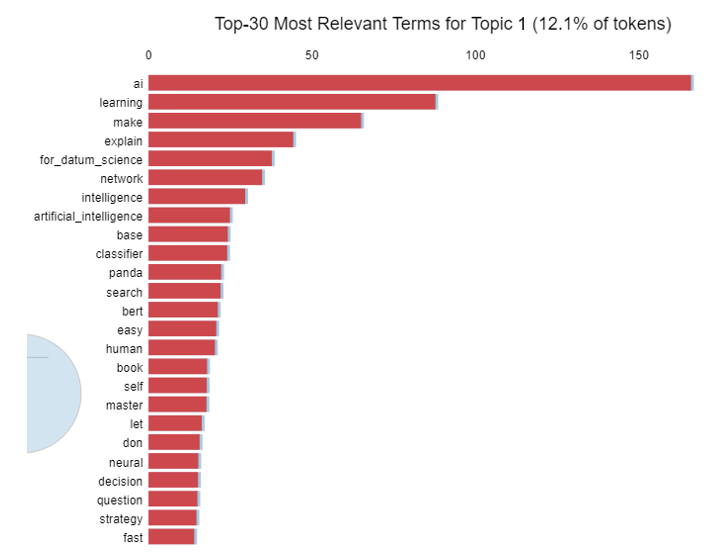

,title
96,AI = “Automated Inspiration”
98,How to be an AI idiot
99,"Training, validation, and test phases in AI — explained in a way you’ll never forget"
105,Artificial Intelligence: Do stupid things faster with more energy!
106,Forget the robots! Here’s how AI will get you
111,What is Decision Intelligence?
115,What if AI model understanding were easy?
120,What is AI bias?
127,Whose fault is it when AI makes mistakes?
130,Explaining supervised learning to a kid (or your boss)


In [38]:
# Reader Interest for Topic 1

plt.figure(figsize=(20,15))
plt.suptitle('Reader Interest: Topic 1 - any topics on AI, explaing ML concepts, links to book resources', fontsize=16)

plt.subplot(2,2,1)
plt.plot(year1_lower_interest,topic1_lower_interest, 'c-',label="Lower Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year1_lower_interest,average1_lower_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average1_lower_interest[-1],(year1_lower_interest[-1],average0_lower_interest[-1]),textcoords="offset points",xytext=(-10,-100))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,2)
plt.plot(year1_decent_interest,topic1_decent_interest, 'b-',label="Decent Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year1_decent_interest,average1_decent_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average1_decent_interest[-1],(year1_decent_interest[-1],average1_decent_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,3)
plt.plot(year1_high_interest,topic1_high_interest, 'g-',label="High Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year1_high_interest,average1_high_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average1_high_interest[-1],(year1_high_interest[-1],average1_high_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,4)
plt.plot(year1_very_high_interest,topic1_very_high_interest, 'r-',label="Very High Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year1_very_high_interest,average1_very_high_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average1_very_high_interest[-1],(year1_very_high_interest[-1],average1_very_high_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.show()

interest_group_distribution = claps_bygroup_freq.groupby(["Interest Grouping","topic_id"]).sum()
interest_group_distribution.columns = ["frequency"]
temp_df = interest_group_distribution.reset_index().set_index("topic_id").loc[1]
temp_df['percentage'] = temp_df['frequency'].apply(lambda x: str(round(x/float(temp_df['frequency'].sum()),2) * 100) + "%" )

sample_df = tds_topics[tds_topics['topic_id']==1]['title'].to_frame()

display_side_by_side(df_topic_names,df_topic_distribution,temp_df)

display(Image(r"C:\Users\ssptit\OneDrive - SAS\Medium\tds_scrape\images\topic1_terms.png"))

display_side_by_side(sample_df[10:20],sample_df[120:130])

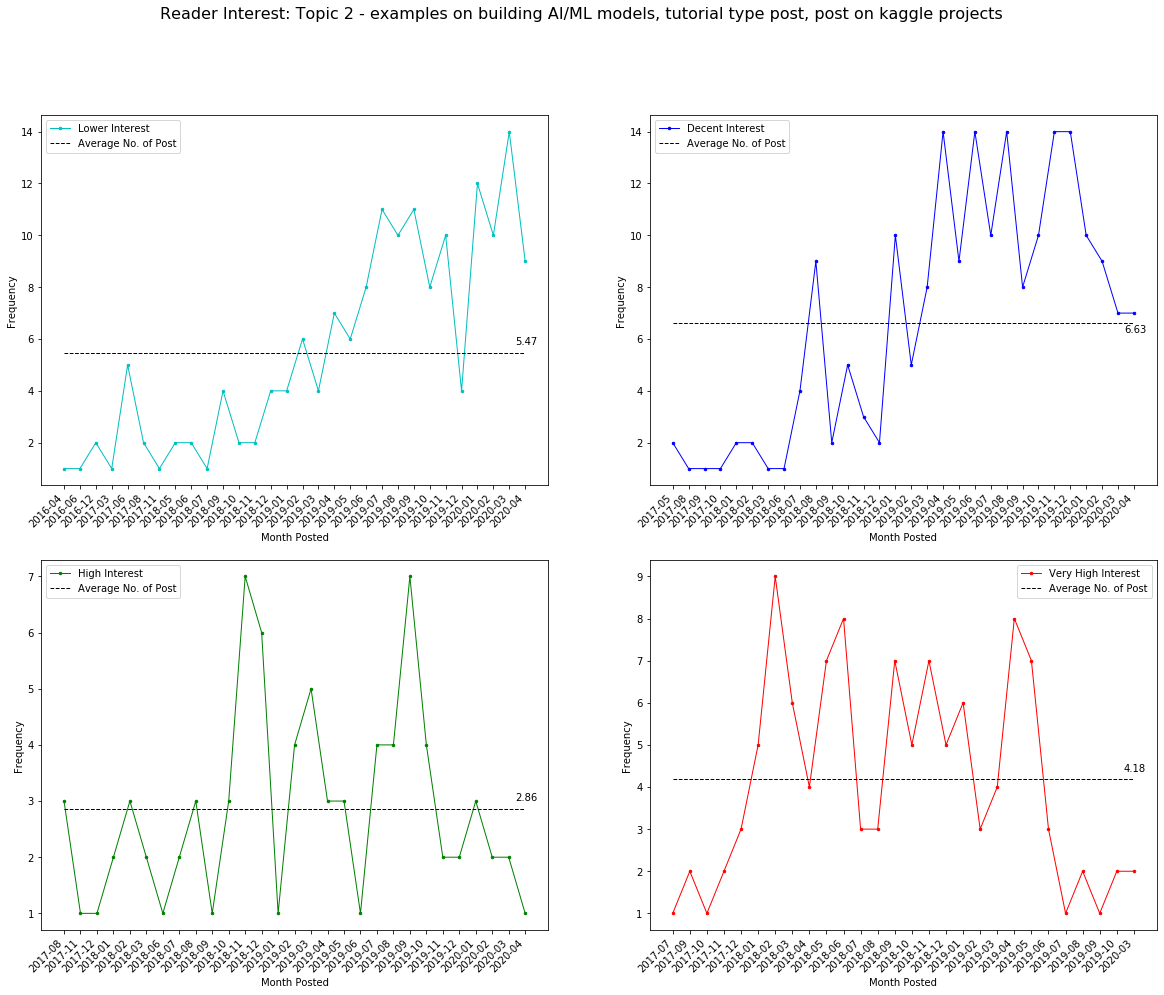

topic_names 
 
 
 topic_id 
 
 
 
 
 
 0 
 feature and functions guides, posts on visualization, pandas or jupyter notebook 
 
 
 1 
 any topics on AI, explaing ML concepts, links to book resources 
 
 
 2 
 examples on building AI/ML models, tutorial type post, post on kaggle projects 
 
 
 3 
 what to learn to enter DS field, "how-to" like posts on data science 
 
 
 4 
 introduction to data science, understanding ML theory, some posts about data science interviews 
 
 
 5 
 posts about data, posts about the DS experiences 
 
 
 6 
 tip and tricks, tensor flow, cloud, techniques 
 
 
 
 
 
 
 num_documents 
 percentage 
 
 
 topic_id 
 
 
 
 
 
 
 0 
 934 
 30.9% 
 
 
 2 
 572 
 19.0% 
 
 
 1 
 453 
 15.0% 
 
 
 5 
 308 
 10.2% 
 
 
 4 
 268 
 8.9% 
 
 
 3 
 262 
 8.7% 
 
 
 6 
 221 
 7.3% 
 
 
 
 
 
 
 Interest Grouping 
 frequency 
 percentage 
 
 
 topic_id 
 
 
 
 
 
 
 
 2 
 Decent Interest 
 199 
 35.0% 
 
 
 2 
 High Interest 
 83 
 15.0% 
 
 
 2 
 Lower Interest 
 173 
 30.0% 
 
 
 2 
 Very High Interest 
 117 
 20.0%

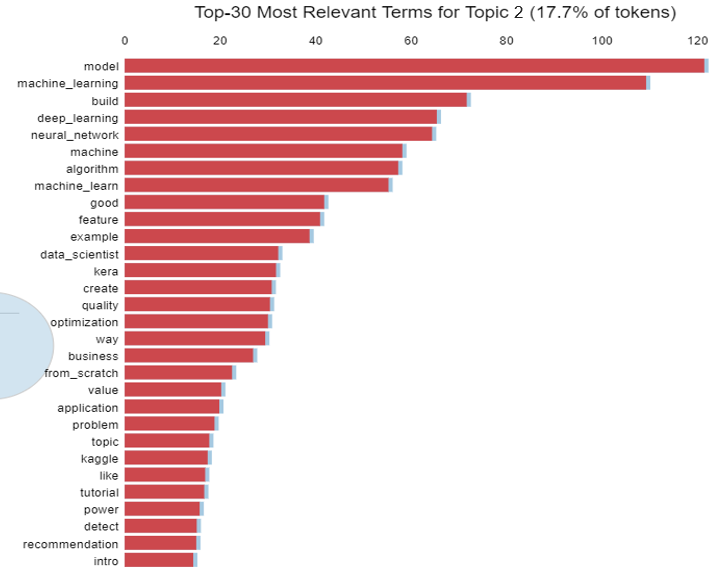

,title
62,Machine Learning Kaggle Competition: Part Three Optimization
65,A Conceptual Explanation of Bayesian Hyperparameter Optimization for Machine Learning
67,Machine Learning Kaggle Competition Part Two: Improving
69,Machine Learning Kaggle Competition Part One: Getting Started
101,Readers’ Choice 10 Best Data Articles
109,10 Best Data Science Reads for Students
114,Why are p-values like needles? It’s dangerous to share them!
141,Most In Demand Tech Skills for Data Engineers
143,Tableau Basics in Six Minutes
144,Build a Portfolio Website in a Flash


In [39]:
# Reader Interest for Topic 2

plt.figure(figsize=(20,15))
plt.suptitle('Reader Interest: Topic 2 - examples on building AI/ML models, tutorial type post, post on kaggle projects', fontsize=16)

plt.subplot(2,2,1)
plt.plot(year2_lower_interest,topic2_lower_interest, 'c-',label="Lower Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year2_lower_interest,average2_lower_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average2_lower_interest[-1],(year2_lower_interest[-1],average2_lower_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,2)
plt.plot(year2_decent_interest,topic2_decent_interest, 'b-',label="Decent Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year2_decent_interest,average2_decent_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average2_decent_interest[-1],(year2_decent_interest[-1],average2_decent_interest[-1]),textcoords="offset points",xytext=(-10,-10))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,3)
plt.plot(year2_high_interest,topic2_high_interest, 'g-',label="High Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year2_high_interest,average2_high_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average2_high_interest[-1],(year2_high_interest[-1],average2_high_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,4)
plt.plot(year2_very_high_interest,topic2_very_high_interest, 'r-',label="Very High Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year2_very_high_interest,average2_very_high_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average2_very_high_interest[-1],(year2_very_high_interest[-1],average2_very_high_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.show()

interest_group_distribution = claps_bygroup_freq.groupby(["Interest Grouping","topic_id"]).sum()
interest_group_distribution.columns = ["frequency"]
temp_df = interest_group_distribution.reset_index().set_index("topic_id").loc[2]
temp_df['percentage'] = temp_df['frequency'].apply(lambda x: str(round(x/float(temp_df['frequency'].sum()),2) * 100) + "%" )

sample_df = tds_topics[tds_topics['topic_id']==2]['title'].to_frame()

display_side_by_side(df_topic_names,df_topic_distribution,temp_df)

display(Image(r"C:\Users\ssptit\OneDrive - SAS\Medium\tds_scrape\images\topic2_terms.png"))

display_side_by_side(sample_df[10:20],sample_df[100:110])

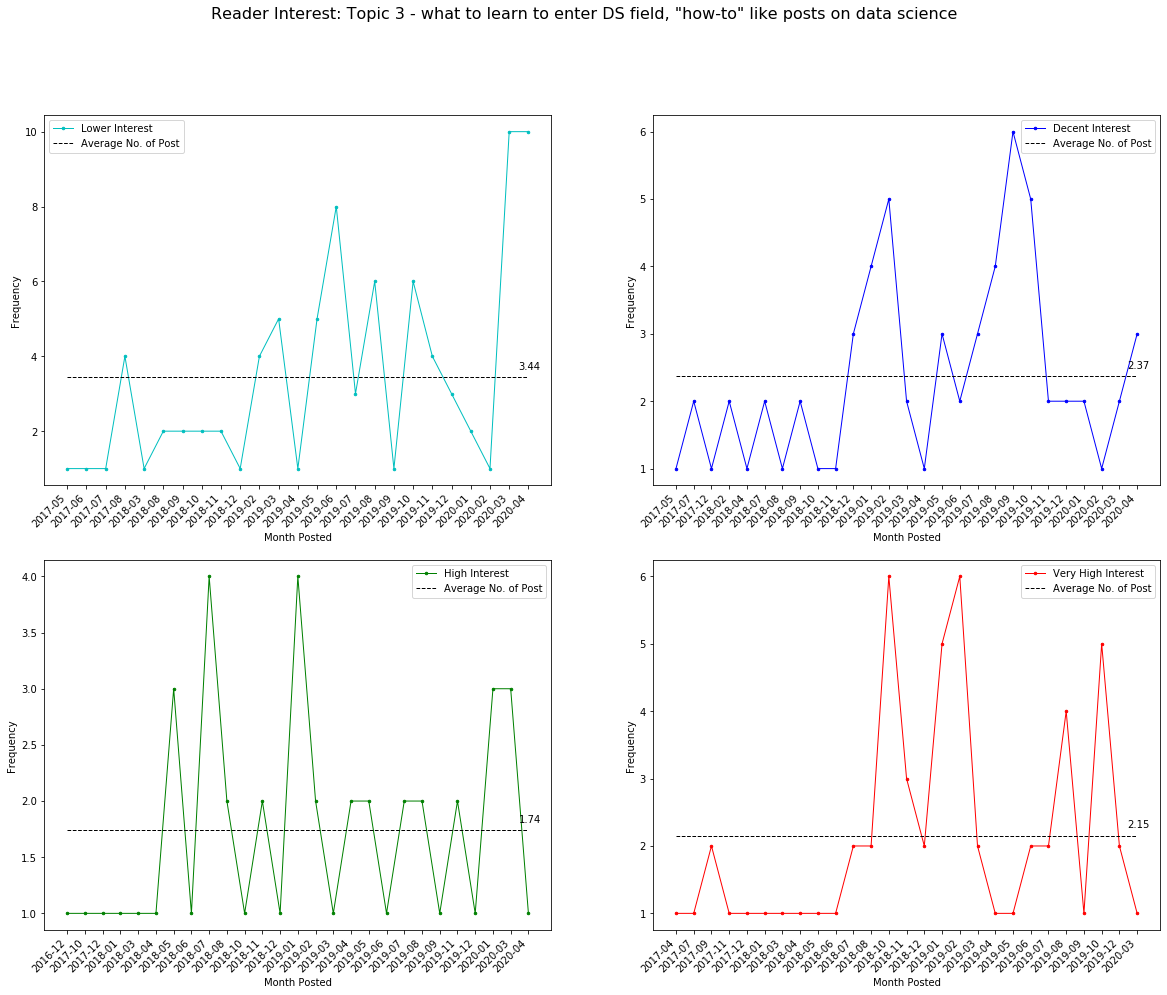

topic_names 
 
 
 topic_id 
 
 
 
 
 
 0 
 feature and functions guides, posts on visualization, pandas or jupyter notebook 
 
 
 1 
 any topics on AI, explaing ML concepts, links to book resources 
 
 
 2 
 examples on building AI/ML models, tutorial type post, post on kaggle projects 
 
 
 3 
 what to learn to enter DS field, "how-to" like posts on data science 
 
 
 4 
 introduction to data science, understanding ML theory, some posts about data science interviews 
 
 
 5 
 posts about data, posts about the DS experiences 
 
 
 6 
 tip and tricks, tensor flow, cloud, techniques 
 
 
 
 
 
 
 num_documents 
 percentage 
 
 
 topic_id 
 
 
 
 
 
 
 0 
 934 
 30.9% 
 
 
 2 
 572 
 19.0% 
 
 
 1 
 453 
 15.0% 
 
 
 5 
 308 
 10.2% 
 
 
 4 
 268 
 8.9% 
 
 
 3 
 262 
 8.7% 
 
 
 6 
 221 
 7.3% 
 
 
 
 
 
 
 Interest Grouping 
 frequency 
 percentage 
 
 
 topic_id 
 
 
 
 
 
 
 
 3 
 Decent Interest 
 65 
 25.0% 
 
 
 3 
 High Interest 
 47 
 18.0% 
 
 
 3 
 Lower Interest 
 91 
 35.0% 
 
 
 3 
 Very High Interest 
 59 
 23.0%

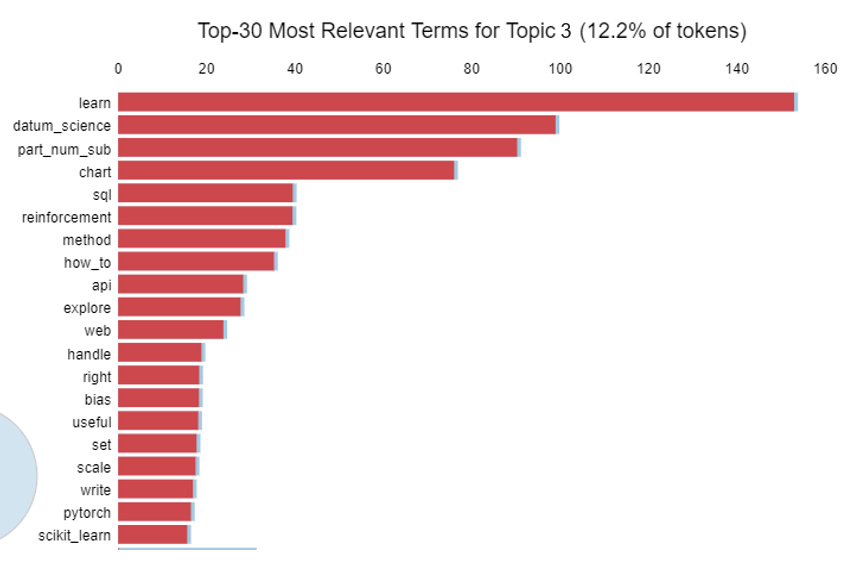

,title
178,Exploring Tableau with Capital Bikeshare and Weather Data
191,Useful String Methods in Python
200,Visualizing Bias in Data using Embedding Projector
239,5 Beginner Friendly Steps to Learn Machine Learning and Data Science with Python
248,An In-depth Review of the Learning How to Learn Course on Coursera
252,A Non-Revolutionary Technique for Learning Data Science in Four Hours Per Day
254,How I’m Learning Deep Learning — Part V
259,How I’m Learning Deep Learning — Part IV
261,How I’m Learning Deep Learning in 2017 — Part 3
262,How I’m Learning Deep Learning In 2017 -Part 2


In [40]:
# Reader Interest for Topic 3

plt.figure(figsize=(20,15))
plt.suptitle('Reader Interest: Topic 3 - what to learn to enter DS field, "how-to" like posts on data science', fontsize=16)

plt.subplot(2,2,1)
plt.plot(year3_lower_interest,topic3_lower_interest, 'c-',label="Lower Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year3_lower_interest,average3_lower_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average3_lower_interest[-1],(year3_lower_interest[-1],average3_lower_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,2)
plt.plot(year3_decent_interest,topic3_decent_interest, 'b-',label="Decent Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year3_decent_interest,average3_decent_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average3_decent_interest[-1],(year3_decent_interest[-1],average3_decent_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,3)
plt.plot(year3_high_interest,topic3_high_interest, 'g-',label="High Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year3_high_interest,average3_high_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average3_high_interest[-1],(year3_high_interest[-1],average3_high_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,4)
plt.plot(year3_very_high_interest,topic3_very_high_interest, 'r-',label="Very High Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year3_very_high_interest,average3_very_high_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average3_very_high_interest[-1],(year3_very_high_interest[-1],average3_very_high_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.show()

interest_group_distribution = claps_bygroup_freq.groupby(["Interest Grouping","topic_id"]).sum()
interest_group_distribution.columns = ["frequency"]
temp_df = interest_group_distribution.reset_index().set_index("topic_id").loc[3]
temp_df['percentage'] = temp_df['frequency'].apply(lambda x: str(round(x/float(temp_df['frequency'].sum()),2) * 100) + "%" )

sample_df = tds_topics[tds_topics['topic_id']==3]['title'].to_frame()

display_side_by_side(df_topic_names,df_topic_distribution,temp_df)

display(Image(r"C:\Users\ssptit\OneDrive - SAS\Medium\tds_scrape\images\topic3_terms.png"))

display_side_by_side(sample_df[25:35],sample_df[100:110])

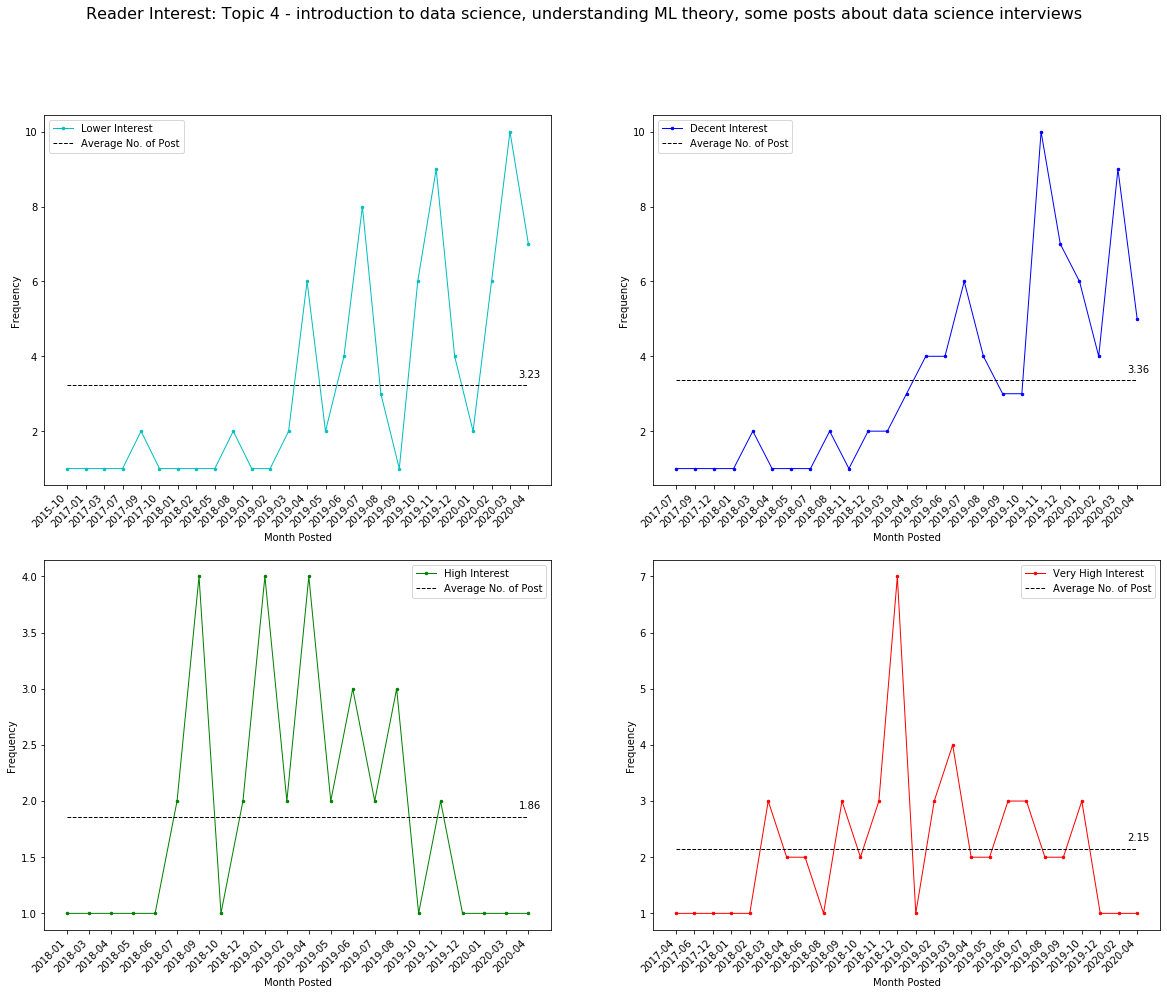

topic_names 
 
 
 topic_id 
 
 
 
 
 
 0 
 feature and functions guides, posts on visualization, pandas or jupyter notebook 
 
 
 1 
 any topics on AI, explaing ML concepts, links to book resources 
 
 
 2 
 examples on building AI/ML models, tutorial type post, post on kaggle projects 
 
 
 3 
 what to learn to enter DS field, "how-to" like posts on data science 
 
 
 4 
 introduction to data science, understanding ML theory, some posts about data science interviews 
 
 
 5 
 posts about data, posts about the DS experiences 
 
 
 6 
 tip and tricks, tensor flow, cloud, techniques 
 
 
 
 
 
 
 num_documents 
 percentage 
 
 
 topic_id 
 
 
 
 
 
 
 0 
 934 
 30.9% 
 
 
 2 
 572 
 19.0% 
 
 
 1 
 453 
 15.0% 
 
 
 5 
 308 
 10.2% 
 
 
 4 
 268 
 8.9% 
 
 
 3 
 262 
 8.7% 
 
 
 6 
 221 
 7.3% 
 
 
 
 
 
 
 Interest Grouping 
 frequency 
 percentage 
 
 
 topic_id 
 
 
 
 
 
 
 
 4 
 Decent Interest 
 84 
 31.0% 
 
 
 4 
 High Interest 
 41 
 15.0% 
 
 
 4 
 Lower Interest 
 86 
 32.0% 
 
 
 4 
 Very High Interest 
 57 
 21.0%

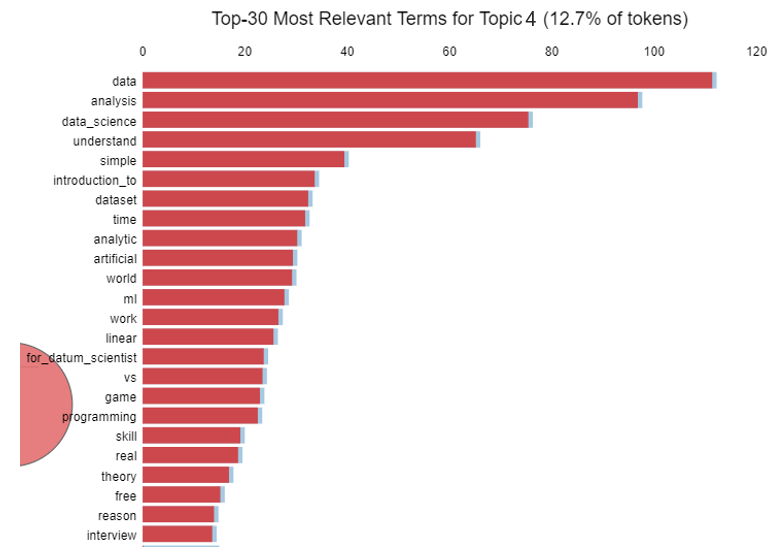

,title
446,An End to End Introduction to GANs
452,"A primer on *args, **kwargs, decorators for Data Scientists"
454,6 bits of advice for Data Scientists
457,My Data Science Blogging Journey on Medium till now
471,Data Scientist — Is it the sexiest job of the 21st Century?
508,Find where to park in real time using OpenCV and Tensorflow
512,Analyze a Soccer game using Tensorflow Object Detection and OpenCV
536,Automating ML Feature Engineering
547,A Brief Introduction to PySpark
568,The Platform Evolution of Game Analytics


In [41]:
# Reader Interest for Topic 4

plt.figure(figsize=(20,15))
plt.suptitle('Reader Interest: Topic 4 - introduction to data science, understanding ML theory, some posts about data science interviews', fontsize=16)

plt.subplot(2,2,1)
plt.plot(year4_lower_interest,topic4_lower_interest, 'c-',label="Lower Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year4_lower_interest,average4_lower_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average4_lower_interest[-1],(year4_lower_interest[-1],average4_lower_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,2)
plt.plot(year4_decent_interest,topic4_decent_interest, 'b-',label="Decent Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year4_decent_interest,average4_decent_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average4_decent_interest[-1],(year4_decent_interest[-1],average4_decent_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,3)
plt.plot(year4_high_interest,topic4_high_interest, 'g-',label="High Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year4_high_interest,average4_high_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average4_high_interest[-1],(year4_high_interest[-1],average4_high_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,4)
plt.plot(year4_very_high_interest,topic4_very_high_interest, 'r-',label="Very High Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year4_very_high_interest,average4_very_high_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average4_very_high_interest[-1],(year4_very_high_interest[-1],average4_very_high_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.show()

interest_group_distribution = claps_bygroup_freq.groupby(["Interest Grouping","topic_id"]).sum()
interest_group_distribution.columns = ["frequency"]
temp_df = interest_group_distribution.reset_index().set_index("topic_id").loc[4]
temp_df['percentage'] = temp_df['frequency'].apply(lambda x: str(round(x/float(temp_df['frequency'].sum()),2) * 100) + "%" )

sample_df = tds_topics[tds_topics['topic_id']==4]['title'].to_frame()

display_side_by_side(df_topic_names,df_topic_distribution,temp_df)

display(Image(r"C:\Users\ssptit\OneDrive - SAS\Medium\tds_scrape\images\topic4_terms.png"))

display_side_by_side(sample_df[50:60],sample_df[100:110])

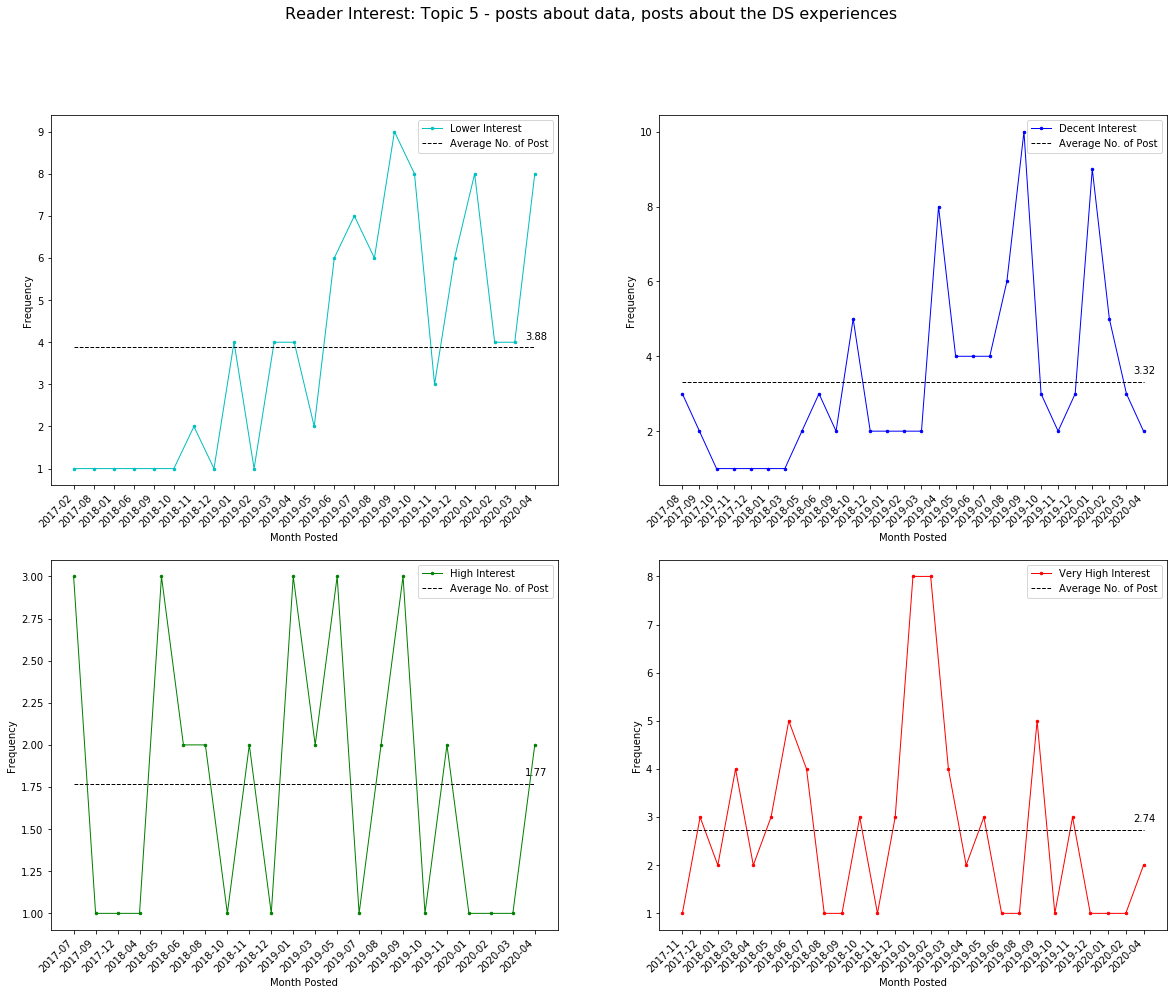

topic_names 
 
 
 topic_id 
 
 
 
 
 
 0 
 feature and functions guides, posts on visualization, pandas or jupyter notebook 
 
 
 1 
 any topics on AI, explaing ML concepts, links to book resources 
 
 
 2 
 examples on building AI/ML models, tutorial type post, post on kaggle projects 
 
 
 3 
 what to learn to enter DS field, "how-to" like posts on data science 
 
 
 4 
 introduction to data science, understanding ML theory, some posts about data science interviews 
 
 
 5 
 posts about data, posts about the DS experiences 
 
 
 6 
 tip and tricks, tensor flow, cloud, techniques 
 
 
 
 
 
 
 num_documents 
 percentage 
 
 
 topic_id 
 
 
 
 
 
 
 0 
 934 
 30.9% 
 
 
 2 
 572 
 19.0% 
 
 
 1 
 453 
 15.0% 
 
 
 5 
 308 
 10.2% 
 
 
 4 
 268 
 8.9% 
 
 
 3 
 262 
 8.7% 
 
 
 6 
 221 
 7.3% 
 
 
 
 
 
 
 Interest Grouping 
 frequency 
 percentage 
 
 
 topic_id 
 
 
 
 
 
 
 
 5 
 Decent Interest 
 94 
 31.0% 
 
 
 5 
 High Interest 
 39 
 13.0% 
 
 
 5 
 Lower Interest 
 100 
 32.0% 
 
 
 5 
 Very High Interest 
 75 
 24.0%

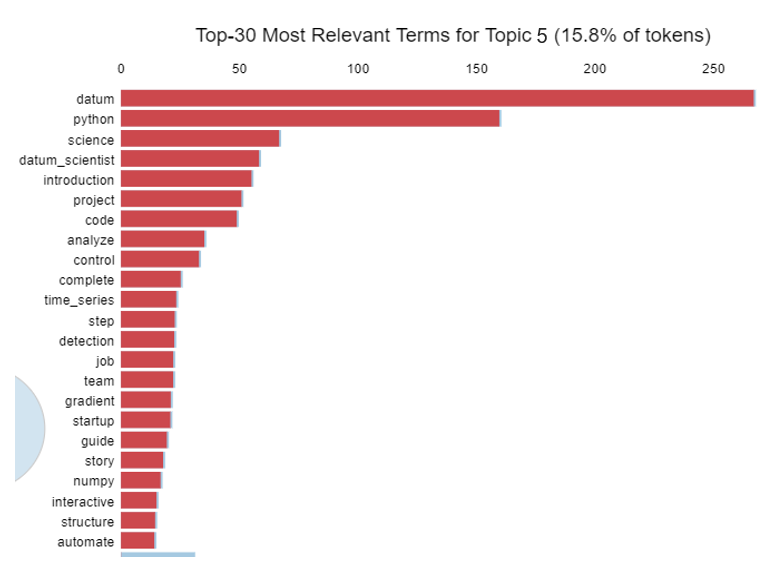

,title
54,"How to Put Fully Interactive, Runnable Code in a Medium Post"
55,A “Data Science for Good” Machine Learning Project Walk-Through in Python: Part Two
56,A “Data Science for Good“ Machine Learning Project Walk-Through in Python: Part One
85,All about data provenance
94,Data science and AI are a mess… and your startup might be making it worse
103,Data Science’s Most Misunderstood Hero
107,Which flavor of data professional are you?
117,Data science effectiveness as a UX problem
119,Data scientist: The sexiest job of the 22nd century
121,What is data?


In [42]:
# Reader Interest for Topic 5

plt.figure(figsize=(20,15))
plt.suptitle('Reader Interest: Topic 5 - posts about data, posts about the DS experiences', fontsize=16)

plt.subplot(2,2,1)
plt.plot(year5_lower_interest,topic5_lower_interest, 'c-',label="Lower Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year5_lower_interest,average5_lower_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average5_lower_interest[-1],(year5_lower_interest[-1],average5_lower_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,2)
plt.plot(year5_decent_interest,topic5_decent_interest, 'b-',label="Decent Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year5_decent_interest,average5_decent_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average5_decent_interest[-1],(year5_decent_interest[-1],average5_decent_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,3)
plt.plot(year5_high_interest,topic5_high_interest, 'g-',label="High Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year5_high_interest,average5_high_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average5_high_interest[-1],(year5_high_interest[-1],average5_high_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,4)
plt.plot(year5_very_high_interest,topic5_very_high_interest, 'r-',label="Very High Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year5_very_high_interest,average5_very_high_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average5_very_high_interest[-1],(year5_very_high_interest[-1],average5_very_high_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.show()

interest_group_distribution = claps_bygroup_freq.groupby(["Interest Grouping","topic_id"]).sum()
interest_group_distribution.columns = ["frequency"]
temp_df = interest_group_distribution.reset_index().set_index("topic_id").loc[5]
temp_df['percentage'] = temp_df['frequency'].apply(lambda x: str(round(x/float(temp_df['frequency'].sum()),2) * 100) + "%" )

sample_df = tds_topics[tds_topics['topic_id']==5]['title'].to_frame()

display_side_by_side(df_topic_names,df_topic_distribution,temp_df)

display(Image(r"C:\Users\ssptit\OneDrive - SAS\Medium\tds_scrape\images\topic5_terms.png"))

display_side_by_side(sample_df[10:20],sample_df[100:110])

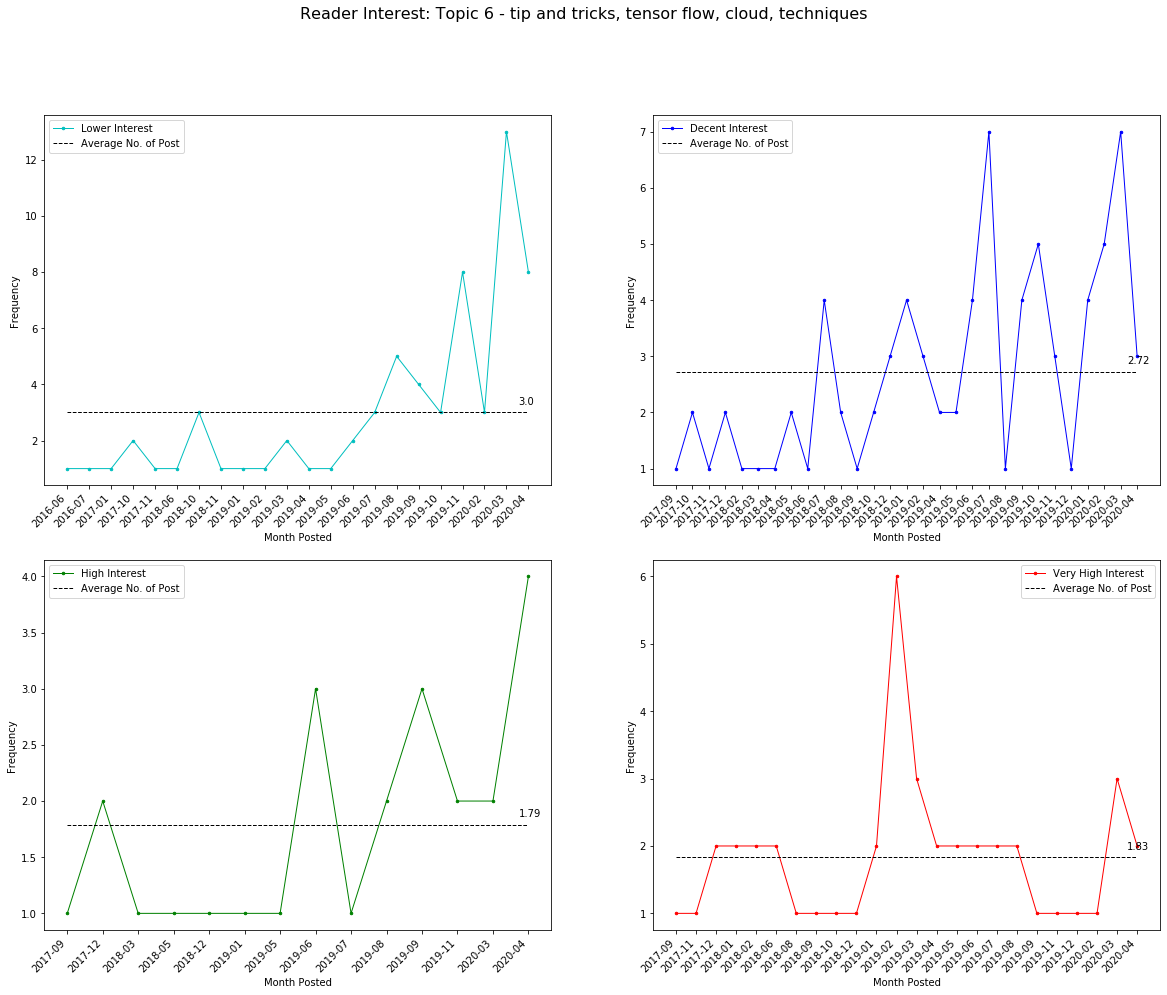

topic_names 
 
 
 topic_id 
 
 
 
 
 
 0 
 feature and functions guides, posts on visualization, pandas or jupyter notebook 
 
 
 1 
 any topics on AI, explaing ML concepts, links to book resources 
 
 
 2 
 examples on building AI/ML models, tutorial type post, post on kaggle projects 
 
 
 3 
 what to learn to enter DS field, "how-to" like posts on data science 
 
 
 4 
 introduction to data science, understanding ML theory, some posts about data science interviews 
 
 
 5 
 posts about data, posts about the DS experiences 
 
 
 6 
 tip and tricks, tensor flow, cloud, techniques 
 
 
 
 
 
 
 num_documents 
 percentage 
 
 
 topic_id 
 
 
 
 
 
 
 0 
 934 
 30.9% 
 
 
 2 
 572 
 19.0% 
 
 
 1 
 453 
 15.0% 
 
 
 5 
 308 
 10.2% 
 
 
 4 
 268 
 8.9% 
 
 
 3 
 262 
 8.7% 
 
 
 6 
 221 
 7.3% 
 
 
 
 
 
 
 Interest Grouping 
 frequency 
 percentage 
 
 
 topic_id 
 
 
 
 
 
 
 
 6 
 Decent Interest 
 81 
 37.0% 
 
 
 6 
 High Interest 
 26 
 12.0% 
 
 
 6 
 Lower Interest 
 70 
 32.0% 
 
 
 6 
 Very High Interest 
 44 
 20.0%

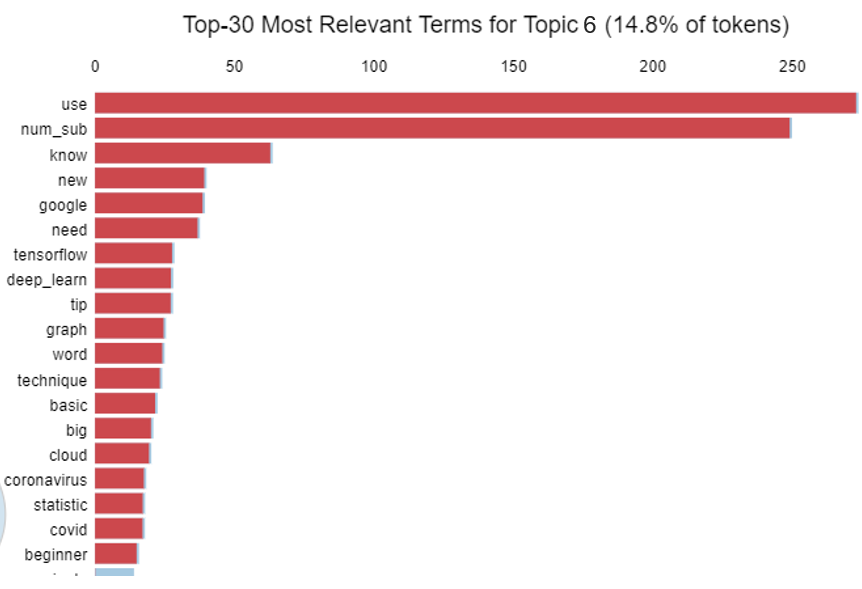

,title
133,9 Things You Should Know about Scikit-Learn 0.23 🎉
134,The 3 Most Important Basic Classification Metrics
146,Top 20 Docker Security Tips
148,10 Days to Become a Google Cloud Certified Professional Data Engineer
158,10 Git Commands You Should Know
162,10 Python File System Methods You Should Know
165,15 Docker Commands You Should Know
172,Best Deals in Deep Learning Cloud Providers
173,List of Deep Learning Cloud Service Providers
197,Basics of BASH for Beginners.


In [43]:
# Reader Interest for Topic 6

plt.figure(figsize=(20,15))
plt.suptitle('Reader Interest: Topic 6 - tip and tricks, tensor flow, cloud, techniques', fontsize=16)

plt.subplot(2,2,1)
plt.plot(year6_lower_interest,topic6_lower_interest, 'c-',label="Lower Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year6_lower_interest,average6_lower_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average6_lower_interest[-1],(year6_lower_interest[-1],average6_lower_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,2)
plt.plot(year6_decent_interest,topic6_decent_interest, 'b-',label="Decent Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year6_decent_interest,average6_decent_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average6_decent_interest[-1],(year6_decent_interest[-1],average6_decent_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,3)
plt.plot(year6_high_interest,topic6_high_interest, 'g-',label="High Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year6_high_interest,average6_high_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average6_high_interest[-1],(year6_high_interest[-1],average6_high_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.subplot(2,2,4)
plt.plot(year6_very_high_interest,topic6_very_high_interest, 'r-',label="Very High Interest",lw=1,marker='o',markersize=2.5)
plt.plot(year6_very_high_interest,average6_very_high_interest,'--',label="Average No. of Post", lw=1, c='k')
plt.annotate(average6_very_high_interest[-1],(year6_very_high_interest[-1],average6_very_high_interest[-1]),textcoords="offset points",xytext=(-10,8))
plt.xlabel('Month Posted')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend()

plt.show()

interest_group_distribution = claps_bygroup_freq.groupby(["Interest Grouping","topic_id"]).sum()
interest_group_distribution.columns = ["frequency"]
temp_df = interest_group_distribution.reset_index().set_index("topic_id").loc[6]
temp_df['percentage'] = temp_df['frequency'].apply(lambda x: str(round(x/float(temp_df['frequency'].sum()),2) * 100) + "%" )

sample_df = tds_topics[tds_topics['topic_id']==6]['title'].to_frame()

display_side_by_side(df_topic_names,df_topic_distribution,temp_df)

display(Image(r"C:\Users\ssptit\OneDrive - SAS\Medium\tds_scrape\images\topic6_terms.png"))

display_side_by_side(sample_df[10:20],sample_df[100:110])